# **0. 준비**
나눔 폰트 설치, 구글 드라이브 연결, 필수 패키지 설치, 시각화 팔레트 확인

In [2]:
# 나눔 폰트 설치 / 한글 깨짐 방지 , 런타임 다시 시작하기
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 6 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 33 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/dejavu: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fo

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='NanumGothic') #matplotlib 한글 깨짐 방지

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
# factor_analyzer 라이브러리 설치
!pip install factor-analyzer

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: python -m pip install --upgrade pip


In [6]:
!pip install shap
import shap

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: python -m pip install --upgrade pip


In [7]:
# 시각화에 사용할 팔레트 확인
plt.style.available

sns.color_palette("pastel")
sns.set(palette='pastel')

----

# **1. 사과 데이터 불러오기**

In [8]:
# 제공받은 후지 사과 데이터 불러오기
df = pd.read_excel("/home/work/.data/data/data.xlsx")

df_fuji = df[df['품종']=='후지']
df_fuji

,조사일,과원이름,품종,시험수,과실번호,과중,종경,횡경,L/D 비,경도1,경도2,당도,산도,착색(L),착색(a),착색(b)
15,2015-11-02,김제,후지,1,1,356.0,85.5,96.4,0.890000,30.913,31.473,16.0,0.439000,47.640,25.710,21.350
16,2015-11-02,김제,후지,1,2,310.0,83.3,91.9,0.910000,26.144,31.174,16.3,NaN,47.130,21.110,19.480
17,2015-11-02,김제,후지,1,3,309.5,82.1,91.8,0.890000,31.902,32.643,10.2,0.397000,51.960,15.070,20.250
18,2015-11-02,김제,후지,1,4,341.0,86.9,92.1,0.940000,32.488,33.291,16.2,NaN,53.830,23.140,26.040
19,2015-11-02,김제,후지,1,5,407.5,88.8,98.9,0.900000,32.260,35.515,15.3,0.289000,52.810,17.130,27.740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,2022-10-27,포천,후지,3,6,276.5,77.2,88.0,0.877273,30.598,30.598,13.6,0.308736,39.780,24.100,15.480
1506,2022-10-27,포천,후지,3,7,250.0,69.9,83.3,0.839136,35.500,35.500,14.6,0.390342,42.765,22.910,16.040
1507,2022-10-27,포천,후지,3,8,284.0,80.8,88.1,0.917140,29.327,29.327,13.9,0.323744,42.720,23.235,15.120
1508,2022-10-27,포천,후지,3,9,359.0,84.9,94.0,0.903191,30.975,30.975,14.4,0.354430,39.120,24.690,14.710


---

# **2. 사과 품질 칼럼 만들기**

target 데이터인 품질 칼럼을 생성하고 이를 예측한다.

품질은 1등급부터 4등급까지 나누며 등급별 기준은 논문 사실에 기재된 농촌진흥청 자료와 소비자 선호 기사를 바탕으로 한다.

* 등급별 기준

    - 과중: 320 / 250 / 215 / 그 미만

    - 당도: 14 / 14/ 12 / 그 미만

    - 당산비: 41 / 36 / 그 미만

In [9]:
# 당산비 칼럼 생성
df_fuji['당산비'] = df_fuji['당도'] / df_fuji['산도']

In [10]:
# 당도, 과중, 당산비 칼럼 null값 평균으로 채우기
mean_values = df_fuji[['당산비', '당도', '과중']].mean()
df_fuji[['당산비', '당도', '과중']] = df_fuji[['당산비', '당도', '과중']].fillna(mean_values)

In [11]:
# '품질' 칼럼 초기화
df_fuji['품질'] = np.nan
df_fuji['품질'] = df_fuji['품질'].astype(str)

# 조건에 따라 '품질' 칼럼 값 설정
for index, row in df_fuji.iterrows():
    if row['당도']>=14 and row['과중']>=320 and row['당산비']>=41 :
        df_fuji.at[index, '품질'] = '1등급'
    elif row['당도']>=14 and row['과중']>=250 and row['당산비']>=36 :
        df_fuji.at[index, '품질'] = '2등급'
    elif row['당도']>=12 and row['과중']>=215:
        df_fuji.at[index, '품질'] = '3등급'
    else:
        df_fuji.at[index, '품질'] = '4등급'

In [12]:
print('1등급 사과 수: ', len(df_fuji[df_fuji['품질']=='1등급']))
print('2등급 사과 수: ', len(df_fuji[df_fuji['품질']=='2등급']))
print('3등급 사과 수: ', len(df_fuji[df_fuji['품질']=='3등급']))
print('4등급 사과 수: ', len(df_fuji[df_fuji['품질']=='4등급']))

1등급 사과 수:  36
2등급 사과 수:  203
3등급 사과 수:  403
4등급 사과 수:  70


In [13]:
df_fuji.head()

,조사일,과원이름,품종,시험수,과실번호,과중,종경,횡경,L/D 비,경도1,경도2,당도,산도,착색(L),착색(a),착색(b),당산비,품질
15,2015-11-02,김제,후지,1,1,356.0,85.5,96.4,0.89,30.913,31.473,16.0,0.439,47.64,25.71,21.35,36.446469,2등급
16,2015-11-02,김제,후지,1,2,310.0,83.3,91.9,0.91,26.144,31.174,16.3,NaN,47.13,21.11,19.48,36.611336,2등급
17,2015-11-02,김제,후지,1,3,309.5,82.1,91.8,0.89,31.902,32.643,10.2,0.397,51.96,15.07,20.25,25.692695,4등급
18,2015-11-02,김제,후지,1,4,341.0,86.9,92.1,0.94,32.488,33.291,16.2,NaN,53.83,23.14,26.04,36.611336,2등급
19,2015-11-02,김제,후지,1,5,407.5,88.8,98.9,0.90,32.260,35.515,15.3,0.289,52.81,17.13,27.74,52.941176,1등급


In [14]:
# 요인분석 진행 후, weather 데이터와 합치기 위한 프레임
fuji_df_fa = df_fuji[['조사일', '과원이름', '품질']]
fuji_df_fa.reset_index(drop=True, inplace=True)
fuji_df_fa

,조사일,과원이름,품질
0,2015-11-02,김제,2등급
1,2015-11-02,김제,2등급
2,2015-11-02,김제,4등급
3,2015-11-02,김제,2등급
4,2015-11-02,김제,1등급
...,...,...,...
707,2022-10-27,포천,3등급
708,2022-10-27,포천,2등급
709,2022-10-27,포천,3등급
710,2022-10-27,포천,2등급


---

# **3. 요인분석용 기상데이터 만들기**








## 1) 기상 데이터 불러오기

 factor_weather
- 주어진 사과 재배 지역의 기상 데이터만으로는 요인 분석을 수행하기에 부족하기 때문에, 기상청에서 추가 데이터를 수집하였다.
- 이 파일에는 강원도 북춘천, 경상남도 전부, 경기도 전부, 전라북도 전부, 대구 전부, 충청북도 전부 (서청주 빼고)의 기상 데이터가 들어있다.

In [15]:
# 요인분석을 위해 사용되는 지역들만 있으므로 변수 factor_weather라고 지정
factor_weather= pd.read_csv("/home/work/.data/data/factor_weather.csv", encoding='cp949')

import datetime
# 원래 날짜 형식과 변경할 날짜 형식 정의
date_formats = ["%y-%m", "%Y-%m"]

# 날짜 형식 변경 함수 정의
def convert_date(date_str):
    # '2016-10' 형식을 파싱하여 '16-10' 형식으로 변경
    year, month = date_str.split('-')
    return f'{year[2:]}-{month}'

# '일시' 열의 값을 변경하고 새로운 열에 저장
factor_weather['일시'] = factor_weather['일시'].apply(convert_date)

## 2) 데이터 프레임 형태 변환
- factor_weather은 지점과, 날짜에 해당하는 기상 데이터이므로 변환이 필요하다.
- 사과 품질 예측을 위해 조사일자로부터 **12개월의 모든 기상데이터가 하나의 데이터를 이루도록** 데이터프레임의 형태를 바꿔주었다.

In [16]:
selected_columns = ['평균기온(°C)', '평균최고기온(°C)', '평균최저기온(°C)', '평균상대습도(%)',
                    '월합강수량(00~24h만)(mm)',  '평균풍속(m/s)', '최대풍속(m/s)',
                     '일조율(%)', '합계 일사량(MJ/m2)', '평균지면온도(°C)']

In [17]:
# 처리할 지점들의 리스트
locations = factor_weather['지점명'].unique().tolist()

# 결과를 저장할 빈 리스트
df_result_list = []

# 빈 데이터프레임 생성
data = {'location': [], 'year': [], 'month': []}
location_df = pd.DataFrame(data)

# 각 지점에 대한 처리를 반복
for location in locations:

    # 해당 지점의 기상 데이터 추출
    location_weather = factor_weather[factor_weather['지점명'] == location].copy()
    location_weather.reset_index(drop=True, inplace=True)

    # '일시' 열을 기반으로 연도와 월을 분리
    location_weather['연도'] = location_weather['일시'].str.split('-').str[0].astype(int)
    location_weather['월'] = location_weather['일시'].str.split('-').str[1].astype(int)

    # 결과 데이터프레임 초기화
    weather_result = pd.DataFrame()

    # 연도별로 데이터를 처리
    for year in range(14, 23):
        year_df = location_weather[location_weather['연도'] == year]

        # 월별로 열을 재구성
        monthly_data = []

        for month in range(1, 13):
            month_data = year_df[year_df['월'] == month][selected_columns].mean()
            monthly_data.extend(month_data)

        # 결과 데이터프레임에 추가
        weather_result = weather_result.append(pd.Series(monthly_data, name=year))

    # 컬럼 이름 재구성
    new_columns = [f"{month}월 {col}" for month in range(1, 13) for col in selected_columns]
    weather_result.columns = new_columns

    # 연도 범위
    years = list(range(15, 23))

    # 월 목록
    months = [8, 9, 10]
    for year in years:
        for month in months:
            location_df = location_df.append({'location': location, 'year': year, 'month': month}, ignore_index=True)

# 처리할 지점들의 리스트
locations = factor_weather['지점명'].unique().tolist()
# 결과를 저장할 빈 리스트
df_result_list = []

# 빈 데이터프레임 생성
data = {'location': [], 'year': [], 'month': []}
location_df = pd.DataFrame(data)

# 각 지점에 대한 처리를 반복
for location in locations:

    # 해당 지점의 기상 데이터 추출
    location_weather = factor_weather[factor_weather['지점명'] == location].copy()
    location_weather.reset_index(drop=True, inplace=True)

    # '일시' 열을 기반으로 연도와 월을 분리
    location_weather['연도'] = location_weather['일시'].str.split('-').str[0].astype(int)
    location_weather['월'] = location_weather['일시'].str.split('-').str[1].astype(int)

    # 결과 데이터프레임 초기화
    weather_result = pd.DataFrame()

    # 연도별로 데이터를 처리
    for year in range(14, 23):
        year_df = location_weather[location_weather['연도'] == year]

        # 월별로 열을 재구성
        monthly_data = []

        for month in range(1, 13):
            month_data = year_df[year_df['월'] == month][selected_columns].mean()
            monthly_data.extend(month_data)

        # 결과 데이터프레임에 추가
        weather_result = weather_result.append(pd.Series(monthly_data, name=year))

    # 컬럼 이름 재구성
    new_columns = [f"{month}월 {col}" for month in range(1, 13) for col in selected_columns]
    weather_result.columns = new_columns

    # 연도 범위
    years = list(range(15, 23))

    # 월 목록
    months = [8, 9, 10]
    for year in years:
        for month in months:
            location_df = location_df.append({'location': location, 'year': year, 'month': month}, ignore_index=True)

    # 24 = 3개월 * 8개년도
    for i in range(24):
        month = int(location_df['month'][i])
        year = int(location_df['year'][i])

        # '조사일' 전년도와 조사일년도 추출
        location_weather = weather_result.loc[[year - 1, year]]
        location_weather_flatten = location_weather.values.flatten()

        # condition = 사용할 기상데이터 종류
        condition = int(len(location_weather_flatten) / 12 / 2)

        data1 = location_weather_flatten[12 * condition:(condition * (12 + month))]
        data2 = location_weather_flatten[(condition * month):12 * condition]
        result = np.hstack((data1, data2))

        df_result = pd.DataFrame({
            '월': [month],
            '연도':[year],
            '지점명' : [location],
            **{f'{int(j/condition)+1}월 평균 기온(°C)': result[j] for j in range(0,12*condition, condition)},
            **{f'{int(j/condition)+1}월 평균 최고기온(°C)': result[j+1] for j in range(0, 12*condition, condition)},
            **{f'{int(j/condition)+1}월 평균 최저기온(°C)': result[j+2] for j in range(0, 12*condition, condition)},
            **{f'{int(j/condition)+1}월 평균 상대습도(%)': result[j+3] for j in range(0, 12*condition, condition)},
            **{f'{int(j/condition)+1}월 월합강수량(00~24h만)(mm)': result[j+4] for j in range(0, 12*condition, condition)},
            **{f'{int(j/condition)+1}월 평균풍속(m/s)': result[j+5] for j in range(0, 12*condition, condition)},
            **{f'{int(j/condition)+1}월 최대풍속(m/s)': result[j+6] for j in range(0, 12*condition, condition)},
            **{f'{int(j/condition)+1}월 일조율(%)': result[j+7] for j in range(0, 12*condition, condition)},
            **{f'{int(j/condition)+1}월 합계 일사량(MJ/m2)': result[j+8] for j in range(0, 12*condition, condition)},
            **{f'{int(j/condition)+1}월 평균지면온도(°C)': result[j+9] for j in range(0, 12*condition, condition)}
        }, index=[0])

        df_result_list.append(df_result)

# 모든 결과를 하나의 데이터프레임으로 병합
final_df_result = pd.concat(df_result_list, ignore_index=True)

final_df_result

,월,연도,지점명,1월 평균 기온(°C),2월 평균 기온(°C),3월 평균 기온(°C),4월 평균 기온(°C),5월 평균 기온(°C),6월 평균 기온(°C),7월 평균 기온(°C),...,3월 평균지면온도(°C),4월 평균지면온도(°C),5월 평균지면온도(°C),6월 평균지면온도(°C),7월 평균지면온도(°C),8월 평균지면온도(°C),9월 평균지면온도(°C),10월 평균지면온도(°C),11월 평균지면온도(°C),12월 평균지면온도(°C)
0,8,15,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,15,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,15,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8,16,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,16,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,9,21,남해,2.3,6.1,10.6,14.3,18.3,22.1,26.1,...,11.9,17.4,21.4,25.8,30.9,30.5,23.8,18.5,11.7,3.5
884,10,21,남해,2.3,6.1,10.6,14.3,18.3,22.1,26.1,...,11.9,17.4,21.4,25.8,30.9,30.5,23.8,18.8,11.7,3.5
885,8,22,남해,2.4,2.8,9.7,14.9,19.1,22.3,26.4,...,11.7,18.6,25.8,26.6,29.3,28.5,23.8,18.8,10.7,4.7
886,9,22,남해,2.4,2.8,9.7,14.9,19.1,22.3,26.4,...,11.7,18.6,25.8,26.6,29.3,28.5,25.2,18.8,10.7,4.7


In [18]:
weather_df_result = final_df_result.copy()

# 연도, 월, 과원이름 묶어서 index로 만들기
weather_df_result.set_index(['월', '연도', '지점명'], inplace=True)

# weather_df_result.to_excel('/home/work/.data/data/apple_weather.xlsx', index=False)
weather_df_result

1월 평균 기온(°C)  2월 평균 기온(°C)  3월 평균 기온(°C)  4월 평균 기온(°C)  \
월  연도 지점명                                                           
8  15 북춘천           NaN           NaN           NaN           NaN   
9  15 북춘천           NaN           NaN           NaN           NaN   
10 15 북춘천           NaN           NaN           NaN           NaN   
8  16 북춘천           NaN           NaN           NaN           NaN   
9  16 북춘천           NaN           NaN           NaN           NaN   
...                 ...           ...           ...           ...   
   21 남해            2.3           6.1          10.6          14.3   
10 21 남해            2.3           6.1          10.6          14.3   
8  22 남해            2.4           2.8           9.7          14.9   
9  22 남해            2.4           2.8           9.7          14.9   
10 22 남해            2.4           2.8           9.7          14.9   

           5월 평균 기온(°C)  6월 평균 기온(°C)  7월 평균 기온(°C)  8월 평균 기온(°C)  \
월  연도 지점명                                                           
8  15 북춘천           NaN           NaN           NaN           NaN   
9  15 북춘천           NaN           NaN           NaN           NaN   
10 15 북춘천           NaN           NaN           NaN           NaN   
8  16 북춘천           NaN           NaN           NaN           NaN   
9  16 북춘천           NaN           NaN           NaN           NaN   
...                 ...           ...           ...           ...   
   21 남해           18.3          22.1          26.1          26.1   
10 21 남해           18.3          22.1          26.1          26.1   
8  22 남해           19.1          22.3          26.4          26.3   
9  22 남해           19.1          22.3          26.4          26.3   
10 22 남해           19.1          22.3          26.4          26.3   

           9월 평균 기온(°C)  10월 평균 기온(°C)  ...  3월 평균지면온도(°C)  4월 평균지면온도(°C)  \
월  연도 지점명                               ...                                 
8  15 북춘천           NaN            NaN  ...            NaN            NaN   
9  15 북춘천           NaN            NaN  ...            NaN            NaN   
10 15 북춘천           NaN            NaN  ...            NaN            NaN   
8  16 북춘천           NaN            NaN  ...            NaN            NaN   
9  16 북춘천           NaN            NaN  ...            NaN            NaN   
...                 ...            ...  ...            ...            ...   
   21 남해           22.2           15.9  ...           11.9           17.4   
10 21 남해           22.2           17.2  ...           11.9           17.4   
8  22 남해           22.2           17.2  ...           11.7           18.6   
9  22 남해           22.1           17.2  ...           11.7           18.6   
10 22 남해           22.1           16.3  ...           11.7           18.6   

           5월 평균지면온도(°C)  6월 평균지면온도(°C)  7월 평균지면온도(°C)  8월 평균지면온도(°C)  \
월  연도 지점명                                                               
8  15 북춘천            NaN            NaN            NaN            NaN   
9  15 북춘천            NaN            NaN            NaN            NaN   
10 15 북춘천            NaN            NaN            NaN            NaN   
8  16 북춘천            NaN            NaN            NaN            NaN   
9  16 북춘천            NaN            NaN            NaN            NaN   
...                  ...            ...            ...            ...   
   21 남해            21.4           25.8           30.9           30.5   
10 21 남해            21.4           25.8           30.9           30.5   
8  22 남해            25.8           26.6           29.3           28.5   
9  22 남해            25.8           26.6           29.3           28.5   
10 22 남해            25.8           26.6           29.3           28.5   

           9월 평균지면온도(°C)  10월 평균지면온도(°C)  11월 평균지면온도(°C)  12월 평균지면온도(°C)  
월  연도 지점명                                                                 
8  15 북춘천            NaN             NaN             NaN             NaN  
9  15 북춘천            NaN             N

---

# **4. 요인분석**
아래의 요인 분석의 결과 요약
- 적합성 검정을 통해 데이터가 요인분석을 하기에 적절한 데이터임을 확인하였다.
- 요인 수를 14로 설정하였다.
- 요인분석의 결과를 보고 새로운 변수 14개를 만들기로 결정하였다.




### 0) 데이터 전처리

In [19]:
# 변수 스케일링
from sklearn.preprocessing import StandardScaler

# 스케일링할 연속형 변수를 선택
continuous_columns = weather_df_result.columns

# StandardScaler 객체 생성
scaler = StandardScaler()
weather_df_result[continuous_columns] = scaler.fit_transform(weather_df_result[continuous_columns])

In [20]:
# 결측치를 평균값으로 대체
weather_df_result = weather_df_result.fillna(weather_df_result.mean())

### 1) 적합성 검정

- 요인 분석을 수행하기 전에 데이터 세트의 “인자 가능성”을 평가해야 한다.
- 요인 분석 가능성은 “데이터 세트에서 요인을 찾을 수 있는가?”를 의미한다.

(1) Bartlett검정

구면성 검정에서는 관측된 상관 행렬을 사용하여 관측된 변수가 단위 행렬과 상호 관련되는지 여부를 확인한다.
* 유의수준을 기준으로 **p값이 0.05 이하**면 요인 분석을 수행해도 괜찮은 정도의 상관관계가 존재한다고 판단한다.

In [21]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

chi_square_value,p_value=calculate_bartlett_sphericity(weather_df_result)

chi_square_value, p_value

(229136.00794395246, 0.0)

(2) KMO(Kaiser-Meyer-Olkin)

KMO값은 표본 적합도를 나타내는 값
* 일반적으로 **0.5 이상**이면 자료가 요인분석에 적절하다고 판단한다.

In [22]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all,kmo_model=calculate_kmo(weather_df_result)

kmo_model

0.8721674510550221

=> 적합성 검정의 결과
 - Bartlett검정의 결과 p값이 0.5 이하이고, KMO 값이 0.5이상이므로 요인 분석을 수행해도 된다.

### 2) 요인 수 선택

요인 수를 선택하는 데 카이저 기준과 스크리 플랏을 사용할 수 있다. 둘 다 고유값을 기반으로 한다.

* 카이저 기준 : 1보다 큰 고유값을 가지는 요인을 선택하는 것을 제안

* 스크리 플랏 : 고유값이 급격하게 감소하는 지점을 '굴곡점' 또는 '깁스 팔꿈치'라고 부르며, 이 지점 이전까지의 요인을 선택

In [23]:
# 카이저 기준
from factor_analyzer import FactorAnalyzer

# 요인 분석 객체 생성
# method='principal' : 주성분분석
fa = FactorAnalyzer(n_factors=15, method='principal', rotation=None)

# 요인 분석 수행
fa.fit(weather_df_result)

# 고유값(eigenvalues) 출력
ev, v = fa.get_eigenvalues()
selected_factors = sum(ev > 1)
selected_factors # => 18개의 요인

18

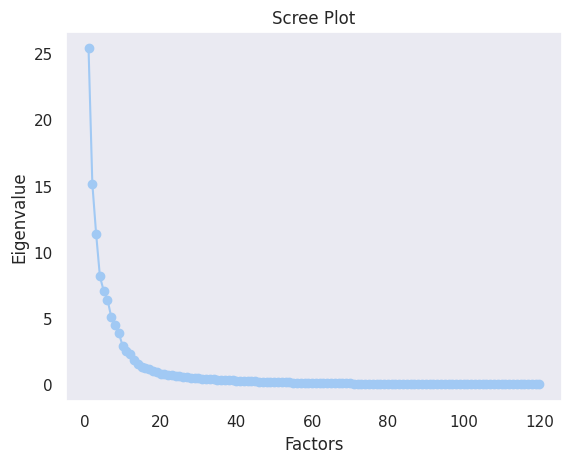

In [24]:
# 시각화
plt.scatter(range(1,weather_df_result.shape[1]+1),ev)
plt.plot(range(1,weather_df_result.shape[1]+1),ev)

plt.title("Scree Plot")
plt.xlabel("Factors")
plt.ylabel("Eigenvalue")
plt.grid()

plt.show()

=> y축 값의 크기가 1 이상인가로 판단한다. 위의 카이저 기준과 비슷하게 요인의 수는 대략 18정도임을 직관적으로 확인할 수 있다.

### 3) 요인분석 수행 + 회전시키기

요인 방법의 회전 방법에는 직각회전과 비직각회전이 있으며, 직각 회전은 요인간에 상관이 없을 때, 비직각회전은 요인간에 상관이 있을 때 사용한다.

* SS Loadings (Sum of Squares Loadings): 각 요인이 설명하는 분산의 합계로, 이 값이 높을수록 해당 요인들이 데이터의 변동성을 많이 설명한다.

* Proportion Variance: 각 요인이 설명하는 분산의 비율로, 전체 분산 대비 해당 요인의 비중을 나타낸다.

* Cumulative Variance: 누적 분산 비율로, 첫 번째 요인부터 순차적으로 더해가며 누적된 분산의 비율을 표시한다. 이를 통해 몇 개의 요인을 선택할지 결정하는 데 도움이 된다.

=> 일반적으로 누적 기여율이 85% 정도가 되는 부분까지만 주성분을 사용한다.

(0) 회전시키지 않고 요인분석 수행

요인 분석을 할 때 유의해야할 점은 요인 회전을 통해서 해석력이 좋은 요인 적재량 행렬을 항상 얻을 수 있는 것은 아니며, 가능성이 있는 것이다.

In [25]:
# 요인 분석 수행
fa_none = FactorAnalyzer(n_factors=18, rotation=None)
fa_none.fit(weather_df_result)

# 요인 로딩 추출
loadings = fa_none.loadings_
loadings_df = pd.DataFrame(loadings, index=weather_df_result.columns, columns=[f'Factor{i}' for i in range(1, 19)])
loadings_df

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18
1월 평균 기온(°C),0.826243,-0.013628,-0.426045,-0.021699,0.229877,-0.009727,-0.122943,-0.044444,0.037581,-0.009136,0.110125,-0.100436,-0.011184,-0.115781,0.034457,0.083349,0.041832,0.058561
2월 평균 기온(°C),0.810448,-0.067844,-0.388844,0.062778,0.029054,-0.024021,-0.197460,0.099051,0.041687,-0.094272,-0.038576,-0.182234,0.232609,0.034484,0.083018,0.010377,0.026469,0.039145
3월 평균 기온(°C),0.758529,-0.302415,-0.040284,0.444156,-0.139816,-0.118759,-0.087907,0.060904,-0.055005,-0.121307,0.017660,0.106265,0.068821,-0.029421,0.044197,0.013496,0.108094,0.006631
4월 평균 기온(°C),0.501831,-0.485269,0.551578,-0.031657,-0.137184,0.251579,0.084909,-0.033330,0.015358,-0.120426,-0.136483,-0.139304,0.012903,-0.006584,0.008820,0.068048,0.111604,-0.027016
5월 평균 기온(°C),0.570872,-0.455023,0.198788,-0.366670,0.329144,-0.048112,-0.016449,0.052091,0.077462,-0.044074,0.192486,0.117802,-0.053659,-0.072231,-0.026492,0.025887,0.120107,0.127950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8월 평균지면온도(°C),0.368654,-0.180301,0.192948,-0.180066,-0.368513,-0.217552,0.148425,0.391467,0.295749,0.058371,0.212835,0.262091,-0.183826,0.039326,0.105674,-0.096459,-0.039961,-0.014841
9월 평균지면온도(°C),0.545024,-0.233612,0.141406,-0.143597,0.059278,0.176851,0.143495,-0.093879,-0.193482,0.026309,0.213290,-0.038773,0.046632,0.192564,0.036816,-0.318548,-0.052903,-0.086737
10월 평균지면온도(°C),0.752961,-0.247440,-0.027465,0.024154,0.051632,0.114762,0.126092,-0.055924,-0.014585,-0.044296,0.057380,-0.232983,-0.194028,-0.002069,-0.020060,-0.188512,-0.130616,-0.081918
11월 평균지면온도(°C),0.832949,-0.094816,-0.140036,-0.180246,-0.146495,0.225560,-0.041927,0.132375,-0.107338,-0.107030,-0.074816,-0.038993,-0.100163,0.062926,0.111589,-0.052809,-0.073428,-0.051599


In [26]:
# (1) 요인 분산 정보 가져오기
factor_variance0 = fa_none.get_factor_variance()

# 요인 분산 정보를 데이터프레임으로 변환
factor_variance_df0 = pd.DataFrame(factor_variance0, index=["SS Loadings", "Proportion Variance", "Cumulative Variance"]).T
factor_variance_df0

,SS Loadings,Proportion Variance,Cumulative Variance
0,25.294833,0.210790,0.210790
1,15.002270,0.125019,0.335809
2,11.249897,0.093749,0.429558
3,7.968562,0.066405,0.495963
4,6.916661,0.057639,0.553602
5,6.230992,0.051925,0.605527
6,4.929358,0.041078,0.646605
7,4.247262,0.035394,0.681999
8,3.659585,0.030497,0.712495
9,2.742381,0.022853,0.735348


(1) 요인의 수를 18개로 회전시키기

In [27]:
# 요인 분석 수행
fa_varimax  = FactorAnalyzer(n_factors=18, rotation="promax")
fa_varimax.fit(weather_df_result)

# 요인 로딩 추출
loadings1 = fa_varimax.loadings_
loadings_df1 = pd.DataFrame(loadings1, index=weather_df_result.columns, columns=[f'Factor{i}' for i in range(1, 19)])
loadings_df1

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18
1월 평균 기온(°C),0.993849,0.039926,-0.223646,0.161420,-0.068854,-0.019762,-0.077135,-0.004391,0.203300,0.099305,0.008878,0.006826,-0.037006,0.019272,0.008154,-0.064768,0.077594,-0.135108
2월 평균 기온(°C),1.037036,-0.027077,-0.019060,-0.179637,-0.027788,-0.085398,-0.157639,-0.011620,0.125083,0.019417,0.084820,0.237159,0.092001,-0.117934,-0.058927,0.045483,-0.045439,-0.026197
3월 평균 기온(°C),0.633710,-0.011830,0.234823,-0.152757,0.138063,0.123013,0.080393,0.005020,0.130822,0.021583,0.244351,-0.165736,0.091761,-0.146189,-0.039532,0.006184,-0.063248,-0.146824
4월 평균 기온(°C),0.455984,0.049748,0.783386,0.072361,0.051445,-0.020754,-0.092626,0.019542,-0.034575,-0.087130,-0.089756,0.011203,0.190903,0.085732,-0.053889,0.040598,-0.131326,-0.059419
5월 평균 기온(°C),0.388831,0.022864,0.032341,0.549066,0.084083,0.083517,0.309944,-0.001176,0.000877,-0.066016,0.005633,0.065864,0.005165,0.050149,0.200190,0.026508,-0.047465,-0.328372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8월 평균지면온도(°C),-0.045517,-0.035341,0.114600,-0.069646,0.048073,-0.034621,0.905700,0.046649,-0.002707,-0.056139,-0.009446,-0.065524,0.011359,-0.039182,0.348564,-0.099021,-0.027278,0.003290
9월 평균지면온도(°C),0.394919,-0.055605,0.065640,0.148409,0.063498,-0.011539,-0.027727,0.009548,-0.140988,-0.039584,-0.031770,0.063758,-0.011058,-0.038627,0.419604,0.458716,-0.086602,0.060238
10월 평균지면온도(°C),0.774997,-0.012471,0.038445,-0.033663,0.067422,0.019347,-0.098700,0.003011,0.010305,-0.112504,-0.262165,0.007358,0.055568,0.021811,0.330259,0.140784,0.175161,0.050467
11월 평균지면온도(°C),0.905338,-0.011617,0.014190,-0.013380,-0.081263,-0.167043,0.047500,-0.013369,-0.251183,-0.104678,0.111340,0.037290,0.066684,-0.005769,0.124182,-0.007605,-0.028256,0.094605


In [28]:
# (1) 요인 분산 정보 가져오기
factor_variance1 = fa_varimax.get_factor_variance()

# 요인 분산 정보를 데이터프레임으로 변환
factor_variance_df1 = pd.DataFrame(factor_variance1, index=["SS Loadings", "Proportion Variance", "Cumulative Variance"]).T
factor_variance_df1

,SS Loadings,Proportion Variance,Cumulative Variance
0,21.256157,0.177135,0.177135
1,14.696367,0.122470,0.299604
2,9.731460,0.081095,0.380700
3,6.128265,0.051069,0.431769
4,5.815562,0.048463,0.480232
5,5.568860,0.046407,0.526639
6,5.397015,0.044975,0.571614
7,5.294673,0.044122,0.615736
8,4.443399,0.037028,0.652765
9,4.407302,0.036728,0.689492


=> Cumulative Variance를 보았을 때 회전한 후에 성능이 더 높다. 대부분의 경우에 회전시켜야 성능이 더 높게 나온다.

=> 일반적으로 자연과학에서는 누적 기여율이 80% 정도만 넘으면 된다. 따라서, 변수의 수를 더 줄이고자 요인의 수를 14개로 축소하겠다.

(2) 요인의 수를 14개로 회전시키기

In [29]:
# 요인 분석 수행
fa_none2  = FactorAnalyzer(n_factors=14, rotation="promax")
fa_none2.fit(weather_df_result)

# 요인 로딩 추출
loadings2 = fa_none2.loadings_
loadings_df2 = pd.DataFrame(loadings2, index=weather_df_result.columns, columns=[f'Factor{i}' for i in range(1, 15)])
loadings_df2

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14
1월 평균 기온(°C),0.948820,0.061449,-0.326897,-0.115266,0.030970,0.154254,-0.015920,-0.089751,0.012814,0.089130,-0.002835,-0.066394,0.020110,-0.141294
2월 평균 기온(°C),0.962003,-0.009917,-0.088884,0.227278,-0.026234,0.116446,-0.058922,-0.149120,-0.004630,0.002909,-0.335931,-0.173087,0.227046,-0.137033
3월 평균 기온(°C),0.615864,-0.009827,0.206511,0.185272,-0.051965,0.222512,0.100856,0.103727,0.016148,-0.268262,0.127034,-0.245858,0.092929,-0.012589
4월 평균 기온(°C),0.492943,0.046282,0.782926,-0.054291,-0.160822,-0.052025,-0.017012,-0.070045,0.010758,0.122350,-0.136401,-0.021977,0.023796,0.096640
5월 평균 기온(°C),0.452556,0.018564,0.005992,-0.555140,-0.274618,0.068811,0.217885,0.344664,0.015317,0.056195,0.022166,0.022468,0.037229,-0.033380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8월 평균지면온도(°C),-0.057605,-0.015274,0.130515,0.067710,0.041178,-0.010373,0.139690,0.945481,0.053198,0.033759,0.155637,0.035955,-0.153291,0.034308
9월 평균지면온도(°C),0.538548,-0.076605,0.218957,-0.224915,0.098141,-0.023315,0.066315,0.027311,0.009540,-0.147570,-0.071430,0.249532,0.320852,0.060932
10월 평균지면온도(°C),0.881072,-0.023397,0.154855,-0.029419,0.014147,0.106435,0.040478,-0.095738,0.009046,0.098957,-0.016547,0.220090,-0.082181,0.071877
11월 평균지면온도(°C),0.866613,0.012909,-0.011673,0.022667,-0.044832,-0.241472,-0.151380,0.058306,-0.015158,-0.105411,-0.091716,0.031893,-0.062309,-0.014162


In [30]:
plt.rc('font', family='NanumGothic') #matplotlib 한글 깨짐 방지

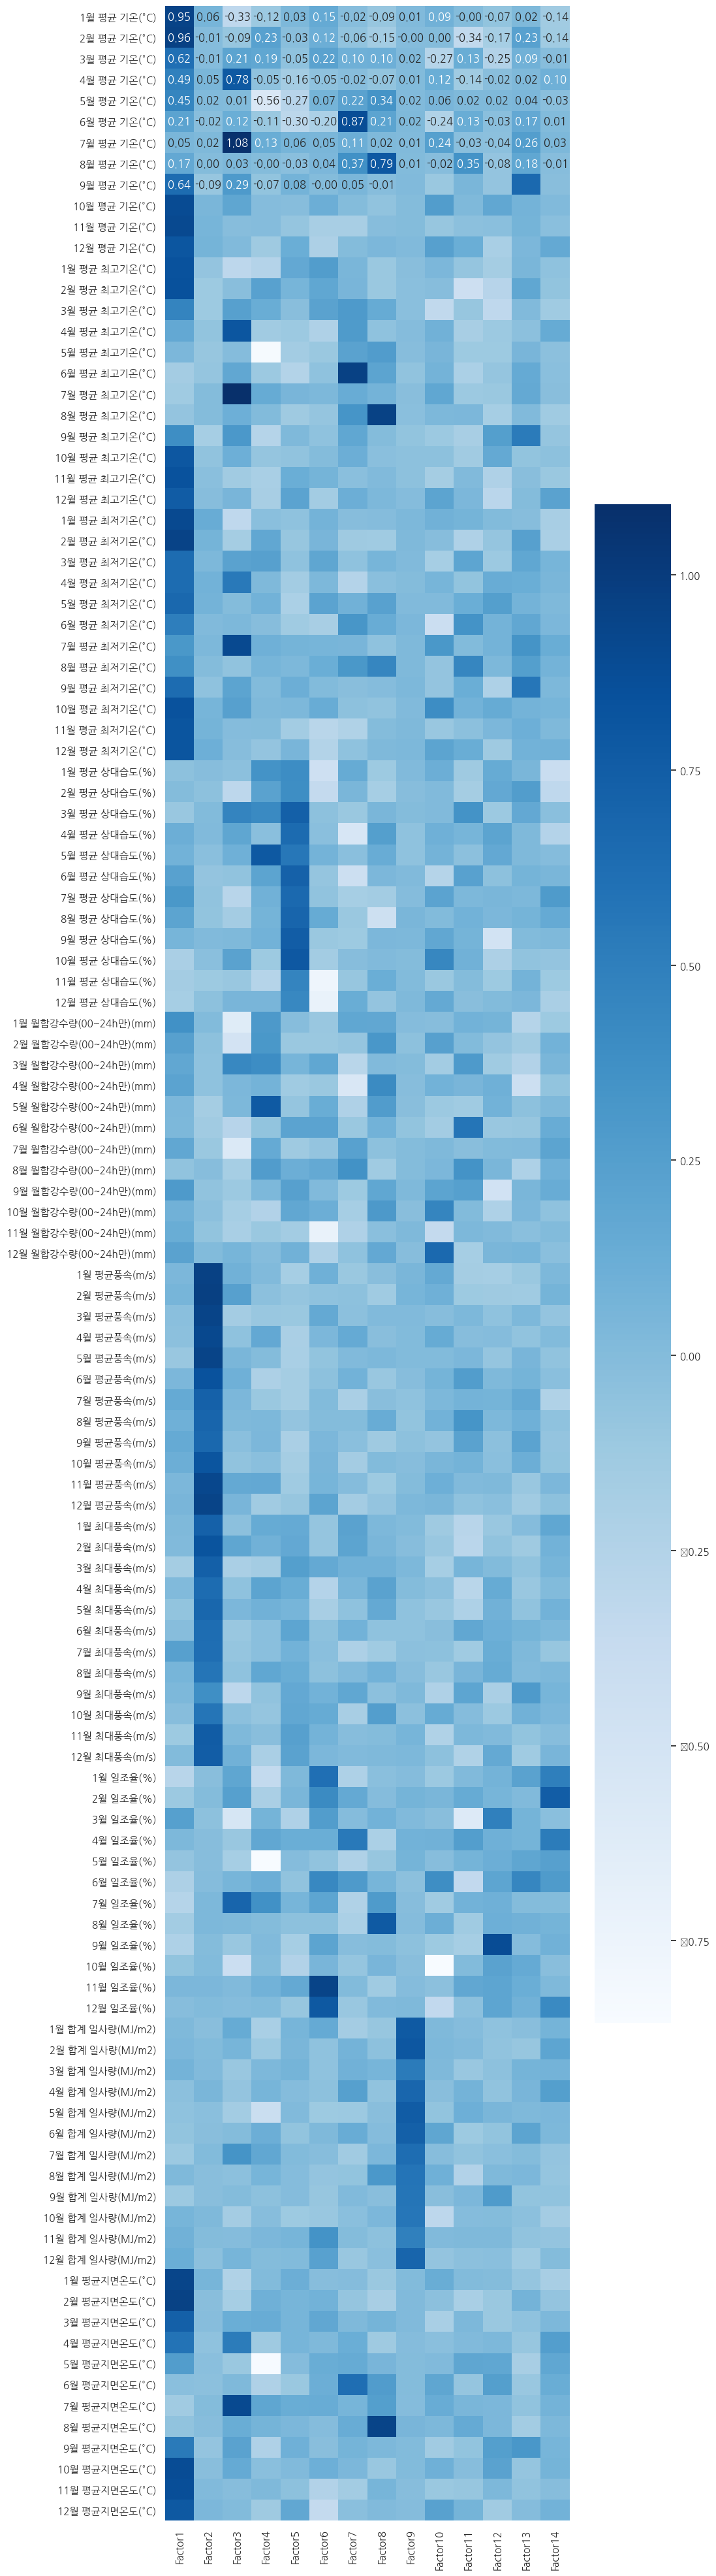

In [31]:
# (0) loadings의 시각화
plt.figure(figsize=(10,50))
sns.heatmap(loadings_df2, cmap="Blues", annot=True, fmt='.2f')
plt.show()

In [32]:
# 각 요인의 주요 변수 살펴보기
for i in range(14):
    sorted_loadings = loadings_df2.iloc[:, i].abs().sort_values(ascending=False)
    print('factor', i+1)
    col = f'Factor{i+1}'
    print(loadings_df2.loc[sorted_loadings.index, col][:12])
    print(loadings_df2.loc[sorted_loadings.index, col][:12].index)
    print('            ')

factor 1
2월 평균 기온(°C)      0.962003
2월 평균지면온도(°C)     0.959436
1월 평균 기온(°C)      0.948820
2월 평균 최저기온(°C)    0.947361
1월 평균지면온도(°C)     0.933774
11월 평균 기온(°C)     0.906648
1월 평균 최저기온(°C)    0.904624
10월 평균 기온(°C)     0.890222
10월 평균지면온도(°C)    0.881072
11월 평균지면온도(°C)    0.866613
2월 평균 최고기온(°C)    0.847099
1월 평균 최고기온(°C)    0.838444
Name: Factor1, dtype: float64
Index(['2월 평균 기온(°C)', '2월 평균지면온도(°C)', '1월 평균 기온(°C)', '2월 평균 최저기온(°C)',
       '1월 평균지면온도(°C)', '11월 평균 기온(°C)', '1월 평균 최저기온(°C)', '10월 평균 기온(°C)',
       '10월 평균지면온도(°C)', '11월 평균지면온도(°C)', '2월 평균 최고기온(°C)', '1월 평균 최고기온(°C)'],
      dtype='object')
            
factor 2
2월 평균풍속(m/s)     0.976242
1월 평균풍속(m/s)     0.963665
3월 평균풍속(m/s)     0.944444
5월 평균풍속(m/s)     0.942659
12월 평균풍속(m/s)    0.939017
11월 평균풍속(m/s)    0.916366
4월 평균풍속(m/s)     0.913352
6월 평균풍속(m/s)     0.832632
2월 최대풍속(m/s)     0.823923
10월 평균풍속(m/s)    0.817214
11월 최대풍속(m/s)    0.757153
12월 최대풍속(m/s)    0.753769
Name: Factor2, dtype: float64
Index(['2월 평균풍속(m/s)'

=> 요인분석의 결과를 보고 각 요인의 주요 변수를 살펴보고 공통점을 찾아 요인 명칭을 정해 모델링을 위한 데이터 프레임을 만들도록 하겠다.

### **요인 분석에 따른 새로운 변수 생성**

1. 1,2월 온도 (top5개)
    
    -> '2월 평균 기온(°C)', '2월 평균지면온도(°C)', '1월 평균 기온(°C)', '2월 평균 최저기온(°C)','1월 평균지면온도(°C)'

2. 평균풍속 (top 7개, 0.9 이상인 값들)
    
    -> '2월 평균풍속(m/s)', '1월 평균풍속(m/s)', '3월 평균풍속(m/s)', '5월 평균풍속(m/s)', '12월 평균풍속(m/s)', '11월 평균풍속(m/s)', '4월 평균풍속(m/s)'

3. 7월의 기온 (top 4개, 0.9 이상인 값들)

    -> '7월 평균 최고기온(°C)', '7월 평균 기온(°C)', '7월 평균 최저기온(°C)', '7월 평균지면온도(°C)'


4. 5월의 온도 (top 3개, 절댓값 0.8 이상)

    -> '5월 일조율(%)', '5월 평균지면온도(°C)', '5월 평균 최고기온(°C)'


5. 평균 상대습도 (top 8개, 0.5 이상)

    -> '10월 평균 상대습도(%)', '9월 평균 상대습도(%)', '3월 평균 상대습도(%)', '6월 평균 상대습도(%)','8월 평균 상대습도(%)', '7월 평균 상대습도(%)', '4월 평균 상대습도(%)', '5월 평균 상대습도(%)'

6. 11월,12월 일조율 (top 2개)
    
    -> '11월 일조율(%)', '12월 일조율(%)'


7. 6월 기온 (top 3개, 양수값들)

    -> '6월 평균 최고기온(°C)', '6월 평균 기온(°C)', '6월 평균지면온도(°C)'

8. 8월 온도 (top 4)

    -> '8월 평균 최고기온(°C)', '8월 평균지면온도(°C)', '8월 평균 기온(°C)', '8월 일조율(%)'


9. 합계일사량 (top 10개)

    -> '2월 합계 일사량(MJ/m2)', '1월 합계 일사량(MJ/m2)', '5월 합계 일사량(MJ/m2)','6월 합계 일사량(MJ/m2)',  '12월 합계 일사량(MJ/m2)', '4월 합계 일사량(MJ/m2)','7월 합계 일사량(MJ/m2)', '8월 합계 일사량(MJ/m2)',  '9월 합계 일사량(MJ/m2)','10월 합계 일사량(MJ/m2)','3월 합계 일사량(MJ/m2)', '11월 합계 일사량(MJ/m2)'


10. 10,12월 월합강수량 (2,3등)

    -> '12월 월합강수량(00~ 24h만)(mm)', '10월 월합강수량(00~24h만)(mm)'

11. 기타 (top 4개, 절댓값 0.4이상)
    
    -> '3월 일조율(%)', '6월 월합강수량(00~24h만)(mm)', '8월 평균 최저기온(°C)','2월 평균 최고기온(°C)'


12. 9월 일조율 (top1개)

    -> '9월 일조율(%)'

13. 9월 온도 (top3개, 0.5이상)

    -> '9월 평균 기온(°C)', '9월 평균 최저기온(°C)', '9월 평균 최고기온(°C)'

14. 12,1,2,4월 일조율 (top4개, 0.4이상)

    -> '2월 일조율(%)', '4월 일조율(%)', '1월 일조율(%)', '12월 일조율(%)'

In [33]:
# (1) 요인 분산 정보 가져오기
## 사회과학에서는 60%, 자연과학에서는 80% 이상의 누적 분산을 가지도록 해야한다.
factor_variance2 = fa_none2.get_factor_variance()

# 요인 분산 정보를 데이터프레임으로 변환
factor_variance_df2 = pd.DataFrame(factor_variance2, index=["SS Loadings", "Proportion Variance", "Cumulative Variance"]).T
factor_variance_df2

,SS Loadings,Proportion Variance,Cumulative Variance
0,21.706149,0.180885,0.180885
1,14.678795,0.122323,0.303208
2,10.457811,0.087148,0.390356
3,6.442627,0.053689,0.444045
4,6.382354,0.053186,0.497231
5,6.253896,0.052116,0.549347
6,5.709281,0.047577,0.596924
7,5.420614,0.045172,0.642096
8,5.305914,0.044216,0.686312
9,4.219999,0.035167,0.721479


In [34]:
# (2) 공통성 구하기 - 각 변수의 요인 적재값의 제곱합 의미 , 각 변수로부터 추출된 요인에 의해 설명되는 비율
## 보통 0.5 이상이면 충분한 공통성을 가진다고 판단한다.
pd.DataFrame(fa_none2.get_communalities(), index=weather_df_result.columns)

,0
1월 평균 기온(°C),1.090139
2월 평균 기온(°C),1.238228
3월 평균 기온(°C),0.687104
4월 평균 기온(°C),0.938901
5월 평균 기온(°C),0.766674
...,...
8월 평균지면온도(°C),0.994581
9월 평균지면온도(°C),0.605645
10월 평균지면온도(°C),0.894521
11월 평균지면온도(°C),0.863322


=> 83%의 누적 분산을 가지고, 충분한 공통성을 가지므로 14개의 요인을 사용하는 것은 적절하다.


---

# **5. 모델링을 위한 데이터 프레임 만들기**
- 품질과 조사일, 그리고 수확일을 기준으로 12개월 전의 모든 기상 데이터가 한 행을 이루도록 한다.
- 조사일의 '일'이 15 이하이면 해당 월을 기상 데이터를 포함하지 않고, 15 초과이면 해당 월의 기상 데이터를 포함하도록 한다.

    ex) 2020년 9월 10일 수확 -> 2019년 9월 ~ 2020년 8월의 기상 데이터

    2020년 9월 24일 수확 -> 2019년 10월 ~ 2020년 9월의 기상 데이터

In [35]:
fuji_df_fa

,조사일,과원이름,품질
0,2015-11-02,김제,2등급
1,2015-11-02,김제,2등급
2,2015-11-02,김제,4등급
3,2015-11-02,김제,2등급
4,2015-11-02,김제,1등급
...,...,...,...
707,2022-10-27,포천,3등급
708,2022-10-27,포천,2등급
709,2022-10-27,포천,3등급
710,2022-10-27,포천,2등급


<참고>

- 화성 -> 경기도 수원시
- 포천 -> 경기도 동두천
- 김제 -> 전북 전주 ( 군산이랑 비교시 거리가 비교적 가까움 )
- 완주 -> 전북 전주
- 남해 -> 경상남도 남해
- 충주 3개 -> 충청북도 충주
- 춘천 -> 강원도 북춘천
- 군위 -> 대구

In [36]:
# 후지 프레임에 '기상지점' 칼럼 추가
# 각 과원에서 가장 가까운 기상 관측지점으로 추가하였다.
fuji_df_fa['기상지점'] = fuji_df_fa['과원이름'].map({
    '화성': '수원',
    '포천': '동두천',
    '김제': '전주',
    '완주': '전주',
    '남해': '남해',
    '충주': '충주',
    '춘천': '북춘천',
    '군위': '대구'
})

fuji_df_fa

,조사일,과원이름,품질,기상지점
0,2015-11-02,김제,2등급,전주
1,2015-11-02,김제,2등급,전주
2,2015-11-02,김제,4등급,전주
3,2015-11-02,김제,2등급,전주
4,2015-11-02,김제,1등급,전주
...,...,...,...,...
707,2022-10-27,포천,3등급,동두천
708,2022-10-27,포천,2등급,동두천
709,2022-10-27,포천,3등급,동두천
710,2022-10-27,포천,2등급,동두천


In [37]:
final_df_result

,월,연도,지점명,1월 평균 기온(°C),2월 평균 기온(°C),3월 평균 기온(°C),4월 평균 기온(°C),5월 평균 기온(°C),6월 평균 기온(°C),7월 평균 기온(°C),...,3월 평균지면온도(°C),4월 평균지면온도(°C),5월 평균지면온도(°C),6월 평균지면온도(°C),7월 평균지면온도(°C),8월 평균지면온도(°C),9월 평균지면온도(°C),10월 평균지면온도(°C),11월 평균지면온도(°C),12월 평균지면온도(°C)
0,8,15,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,15,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,15,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8,16,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,16,북춘천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,9,21,남해,2.3,6.1,10.6,14.3,18.3,22.1,26.1,...,11.9,17.4,21.4,25.8,30.9,30.5,23.8,18.5,11.7,3.5
884,10,21,남해,2.3,6.1,10.6,14.3,18.3,22.1,26.1,...,11.9,17.4,21.4,25.8,30.9,30.5,23.8,18.8,11.7,3.5
885,8,22,남해,2.4,2.8,9.7,14.9,19.1,22.3,26.4,...,11.7,18.6,25.8,26.6,29.3,28.5,23.8,18.8,10.7,4.7
886,9,22,남해,2.4,2.8,9.7,14.9,19.1,22.3,26.4,...,11.7,18.6,25.8,26.6,29.3,28.5,25.2,18.8,10.7,4.7


In [38]:
# 처리할 지점들의 리스트
locations = ['전주', '북춘천', '동두천', '수원', '충주', '대구', '남해']

# 결과를 저장할 빈 리스트
df_result_list = []

# 각 지점에 대한 처리를 반복
for location in locations:

    # 해당 지점의 기상 데이터 추출
    location_weather = final_df_result[final_df_result['지점명'] == location]
    location_weather.reset_index(drop=True, inplace=True)

    # 해당 지점 (타겟이 있는) 데이터프레임 추출
    location_df = fuji_df_fa[fuji_df_fa['기상지점'] == location]
    location_df['조사일'] = pd.to_datetime(location_df['조사일'])  # 데이트타임으로 변환
    location_df.drop('기상지점', axis=1, inplace=True)
    location_df.reset_index(drop=True, inplace=True)  # 인덱스 초기화

    n = len(location_df)

    for i in range(n):
        year = int(str(location_df['조사일'][i])[2:4])
        month = int(str(location_df['조사일'][i])[5:7])
        day = int(str(location_df['조사일'][i])[8:10])

        # 15일 전에는 '조사일'에 해당하는 월 제외
        if day <= 15:
            month = month - 1
        else:
            month = month

        data1 = pd.DataFrame(location_df.iloc[i]).T  # data1을 데이터프레임으로 변환
        data1.reset_index(drop=True, inplace=True)
        data2 = location_weather[(location_weather['월'] == month) & (location_weather['연도'] == year)]
        data2.drop(['월', '연도', '지점명'], axis=1, inplace=True)
        data2 = data2.iloc[0:1]  # 하나의 행만 선택하여 데이터프레임으로 변환
        data2.reset_index(drop=True, inplace=True)

        # 두 데이터프레임을 합치기 (concatenate)
        df_result = pd.concat([data1, data2], axis=1)
        df_result_list.append(df_result)

# 모든 결과를 하나의 데이터프레임으로 병합
result = pd.concat(df_result_list)
result

,조사일,과원이름,품질,1월 평균 기온(°C),2월 평균 기온(°C),3월 평균 기온(°C),4월 평균 기온(°C),5월 평균 기온(°C),6월 평균 기온(°C),7월 평균 기온(°C),...,3월 평균지면온도(°C),4월 평균지면온도(°C),5월 평균지면온도(°C),6월 평균지면온도(°C),7월 평균지면온도(°C),8월 평균지면온도(°C),9월 평균지면온도(°C),10월 평균지면온도(°C),11월 평균지면온도(°C),12월 평균지면온도(°C)
0,2015-11-02,김제,2등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,11.2,16.6,24.0,26.8,27.3,29.6,25.6,18.0,10.4,2.7
0,2015-11-02,김제,2등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,11.2,16.6,24.0,26.8,27.3,29.6,25.6,18.0,10.4,2.7
0,2015-11-02,김제,4등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,11.2,16.6,24.0,26.8,27.3,29.6,25.6,18.0,10.4,2.7
0,2015-11-02,김제,2등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,11.2,16.6,24.0,26.8,27.3,29.6,25.6,18.0,10.4,2.7
0,2015-11-02,김제,1등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,11.2,16.6,24.0,26.8,27.3,29.6,25.6,18.0,10.4,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2019-10-24,남해,4등급,2.9,5.1,9.8,13.4,19.6,21.8,25.1,...,11.6,15.9,21.4,25.6,27.6,30.5,24.0,19.0,10.6,4.5
0,2019-10-24,남해,4등급,2.9,5.1,9.8,13.4,19.6,21.8,25.1,...,11.6,15.9,21.4,25.6,27.6,30.5,24.0,19.0,10.6,4.5
0,2019-10-24,남해,4등급,2.9,5.1,9.8,13.4,19.6,21.8,25.1,...,11.6,15.9,21.4,25.6,27.6,30.5,24.0,19.0,10.6,4.5
0,2019-10-24,남해,4등급,2.9,5.1,9.8,13.4,19.6,21.8,25.1,...,11.6,15.9,21.4,25.6,27.6,30.5,24.0,19.0,10.6,4.5


In [39]:
# 명칭 변경
fuji_df_factor = result.copy()

---

# **6. 새로운 변수 추가**

## 1) 태풍

-> 태풍은 수확기에 가까운 태풍에만 영향을 받으므로 작년 수확기 이후의 태풍은 고려하지 않는다. 즉, 당해 연도의 태풍 발생만 고려하였다.

따라서 지금까지 기상데이터는 월별 데이터였지만 태풍 칼럼은 연도별 데이터로 입력된다.

* 연도별 발생 횟수:

    2015: 4회   |   2016: 2회   |  2017: 3회

    2018: 5회   |   2019: 7회   |  2020: 4회

    2021: 3회   |   2022: 5회

* 태풍 평균 강도 = 각 태풍의 최대 풍속 / 당해 연도 발생 횟수

In [40]:
# 조사일에서 연도 추출
fuji_df_factor['조사연도'] = 0
for i in range(len(fuji_df_factor)):
    fuji_df_factor['조사연도'].iloc[i] = fuji_df_factor['조사일'].iloc[i].year

fuji_df_factor.head()

,조사일,과원이름,품질,1월 평균 기온(°C),2월 평균 기온(°C),3월 평균 기온(°C),4월 평균 기온(°C),5월 평균 기온(°C),6월 평균 기온(°C),7월 평균 기온(°C),...,4월 평균지면온도(°C),5월 평균지면온도(°C),6월 평균지면온도(°C),7월 평균지면온도(°C),8월 평균지면온도(°C),9월 평균지면온도(°C),10월 평균지면온도(°C),11월 평균지면온도(°C),12월 평균지면온도(°C),조사연도
0,2015-11-02,김제,2등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,16.6,24.0,26.8,27.3,29.6,25.6,18.0,10.4,2.7,2015
0,2015-11-02,김제,2등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,16.6,24.0,26.8,27.3,29.6,25.6,18.0,10.4,2.7,2015
0,2015-11-02,김제,4등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,16.6,24.0,26.8,27.3,29.6,25.6,18.0,10.4,2.7,2015
0,2015-11-02,김제,2등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,16.6,24.0,26.8,27.3,29.6,25.6,18.0,10.4,2.7,2015
0,2015-11-02,김제,1등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,16.6,24.0,26.8,27.3,29.6,25.6,18.0,10.4,2.7,2015


In [41]:
# 2015~2022년 태풍횟수와 태풍평균강도 칼럼 생성
fuji_df_factor['태풍횟수'] = fuji_df_factor['조사연도'].map({
        2015: 4,
        2016: 2,
        2017: 3,
        2018: 5,
        2019: 7,
        2020: 4,
        2021: 3,
        2022: 5
})

fuji_df_factor['태풍평균강도'] = fuji_df_factor['조사연도'].map({
        2015: 54.25,
        2016: 49.5,
        2017: 41,
        2018: 40.2,
        2019: 38.57,
        2020: 42,
        2021: 34,
        2022: 33.6
})

## 2) 폭염 일수

- 폭염 일수 : 지역 별로 각 수확년도에 체감온도가 33도 이상이었던 날 횟수
- 태풍 변수와 마찬가지로 연도별 데이터로 입력한다.

In [42]:
hot_dict = {
    '충주': [12, 28, 12, 37, 16, 6, 16, 10],
    '김제': [17, 39, 29, 48, 32, 25, 24, 22],
    '완주': [17, 39, 29, 48, 32, 25, 24, 22],
    '남해': [13, 37, 35, 42, 22, 14, 14, 9],
    '포천': [8, 31, 17, 36, 17, 9, 25, 15],
    '화성': [17, 37, 25, 41, 20, 14, 27, 17],
    '군위': [16, 29, 28, 35, 22, 29, 17, 39],
    '춘천': [None, None, 14, 29, 15, 10, 24, 16]
}

for region in hot_dict.keys():
    hot_list = hot_dict[region]
    for year, hot_days in zip(range(2015, 2023), hot_list):
        fuji_df_factor.loc[(fuji_df_factor['과원이름'] == region) & (fuji_df_factor['조사연도'] == year), '폭염일수'] = hot_days

## 3) 장마

: 조사연도에 따른 장마 일수와 합계 강수량 두 개의 칼럼 추가

In [43]:
# 장마 일수
rain_days = {
    '충주': [35, 37, 29, 16, 34, 54, 17, 33],
    '김제': [36, 29, 31, 14, 33, 38, 17, 33],
    '완주': [36, 29, 31, 14, 33, 38, 17, 33],
    '남해': [36, 29, 31, 14, 33, 38, 17, 33],
    '포천': [35, 37, 29, 16, 34, 54, 17, 33],
    '화성': [35, 37, 29, 16, 34, 54, 17, 33],
    '군위': [36, 29, 31, 14, 33, 38, 17, 33],
    '춘천': [35, 37,29, 16, 34, 54, 17, 33]
}

for region in rain_days.keys():
    rain_day = rain_days[region]
    for year, days in zip(range(2015, 2023), rain_day):
        fuji_df_factor.loc[(fuji_df_factor['과원이름'] == region) & (fuji_df_factor['조사연도'] == year), '장마일수'] = days

In [44]:
# 합계 강수량
total_precipi_dict = {
    '충주': [228.3, 399.8, 375.3, 209.4, 169.1, 814.3, 304.5, 528],
    '김제': [193.5, 320.3, 188, 289, 233.1, 682, 220.4, 262.6],
    '완주': [193.5, 320.3, 188, 289, 233.1, 682, 220.4, 262.6],
    '남해': [420.2, 309.6, 156.9, 482.8, 784.9, 843.6, 503, 249.1],
    '포천': [475.5, 456.1, 575.1, 268.9, 265, 1085.4, 115.8, 558.7],
    '화성': [242.2, 324.3, 579.7, 320.1, 185, 1057.9, 123.7, 622.9],
    '군위': [195, 189, 91.6, 266, 253.9, 381.6, 147.9, 124.8],
    '춘천': [257.8, 625.9, 530.4, 316.7, 174.5, 944.1, 156.4, 525]
}

for region in total_precipi_dict.keys():
    total_precipi_list = total_precipi_dict[region]
    for year, total_precipi in zip(range(2015, 2023), total_precipi_list):
        fuji_df_factor.loc[(fuji_df_factor['과원이름'] == region) & (fuji_df_factor['조사연도'] == year), '합계강수량'] = total_precipi

In [45]:
# 모델링에 사용할 프레임
fuji_df_factor.reset_index(drop=True, inplace=True)
fuji_df_factor

,조사일,과원이름,품질,1월 평균 기온(°C),2월 평균 기온(°C),3월 평균 기온(°C),4월 평균 기온(°C),5월 평균 기온(°C),6월 평균 기온(°C),7월 평균 기온(°C),...,9월 평균지면온도(°C),10월 평균지면온도(°C),11월 평균지면온도(°C),12월 평균지면온도(°C),조사연도,태풍횟수,태풍평균강도,폭염일수,장마일수,합계강수량
0,2015-11-02,김제,2등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,25.6,18.0,10.4,2.7,2015,4,54.25,17.0,36.0,193.5
1,2015-11-02,김제,2등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,25.6,18.0,10.4,2.7,2015,4,54.25,17.0,36.0,193.5
2,2015-11-02,김제,4등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,25.6,18.0,10.4,2.7,2015,4,54.25,17.0,36.0,193.5
3,2015-11-02,김제,2등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,25.6,18.0,10.4,2.7,2015,4,54.25,17.0,36.0,193.5
4,2015-11-02,김제,1등급,1.0,2.5,7.2,13.9,19.2,22.7,25.1,...,25.6,18.0,10.4,2.7,2015,4,54.25,17.0,36.0,193.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,2019-10-24,남해,4등급,2.9,5.1,9.8,13.4,19.6,21.8,25.1,...,24.0,19.0,10.6,4.5,2019,7,38.57,22.0,33.0,784.9
708,2019-10-24,남해,4등급,2.9,5.1,9.8,13.4,19.6,21.8,25.1,...,24.0,19.0,10.6,4.5,2019,7,38.57,22.0,33.0,784.9
709,2019-10-24,남해,4등급,2.9,5.1,9.8,13.4,19.6,21.8,25.1,...,24.0,19.0,10.6,4.5,2019,7,38.57,22.0,33.0,784.9
710,2019-10-24,남해,4등급,2.9,5.1,9.8,13.4,19.6,21.8,25.1,...,24.0,19.0,10.6,4.5,2019,7,38.57,22.0,33.0,784.9


---

# **7. EDA**
- 데이터 확인
- 시각화는 다른 파일 참고

In [46]:
fuji_df_factor.describe()

,1월 평균 기온(°C),2월 평균 기온(°C),3월 평균 기온(°C),4월 평균 기온(°C),5월 평균 기온(°C),6월 평균 기온(°C),7월 평균 기온(°C),8월 평균 기온(°C),9월 평균 기온(°C),10월 평균 기온(°C),...,9월 평균지면온도(°C),10월 평균지면온도(°C),11월 평균지면온도(°C),12월 평균지면온도(°C),조사연도,태풍횟수,태풍평균강도,폭염일수,장마일수,합계강수량
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,...,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,-1.618820,0.501124,7.218118,13.073736,18.202528,22.384972,26.279073,26.314607,20.984691,14.370646,...,23.208427,16.073876,7.694242,0.909691,2018.488764,4.390449,40.021545,26.085674,27.443820,410.301124
std,2.403247,2.204458,1.270445,1.284145,0.952231,0.570130,1.229191,1.291097,1.135691,1.776316,...,1.093639,1.608064,1.970259,1.981164,1.737285,1.417916,4.111122,10.707975,11.149524,264.532531
min,-6.000000,-3.400000,4.600000,10.200000,15.800000,21.100000,23.000000,24.200000,19.100000,10.300000,...,21.400000,12.800000,4.600000,-1.500000,2015.000000,2.000000,33.600000,9.000000,14.000000,115.800000
25%,-3.600000,-1.500000,6.500000,12.400000,17.400000,22.100000,25.800000,25.400000,19.800000,13.500000,...,22.600000,15.100000,6.200000,-1.100000,2017.000000,3.000000,38.570000,17.000000,16.000000,209.400000
50%,-2.200000,0.800000,7.200000,13.200000,18.400000,22.400000,26.300000,26.700000,21.100000,14.300000,...,23.000000,16.100000,6.800000,0.600000,2018.000000,5.000000,40.200000,25.000000,29.000000,316.700000
75%,0.600000,2.400000,7.900000,13.900000,18.800000,22.700000,27.100000,27.200000,21.900000,16.000000,...,23.700000,16.800000,10.200000,1.875000,2020.000000,5.000000,41.000000,35.000000,33.000000,558.700000
max,2.900000,5.100000,9.800000,15.400000,19.800000,23.600000,28.200000,28.600000,22.700000,17.600000,...,25.900000,19.000000,11.500000,5.000000,2022.000000,7.000000,54.250000,48.000000,54.000000,1085.400000


In [47]:
fuji_df_factor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Columns: 129 entries, 조사일 to 합계강수량
dtypes: datetime64[ns](1), float64(124), int64(2), object(2)
memory usage: 717.7+ KB


---

# **8. 데이터 전처리 및 최종 데이터 프레임 만들기**

## 1) 데이터 전처리

In [48]:
# 타겟변수 인코딩
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# '품질' 칼럼 라벨 인코딩
fuji_df_factor['품질'] = label_encoder.fit_transform(fuji_df_factor['품질'])

In [49]:
# 조사일, 조사연도, 과원이름 데이터 삭제
fuji_df_factor = fuji_df_factor.drop(['조사일','조사연도','과원이름'],axis=1)

In [50]:
# 요인분석에서 제거된 최대풍속 칼럼 없애기
columns_to_remove = [col for col in fuji_df_factor.columns if '최대풍속(m/s)' in col]
fuji_df_factor.drop(columns=columns_to_remove, inplace=True)

In [51]:
# 타겟변수와 피처 구분
X = fuji_df_factor.drop('품질',axis=1)
y = fuji_df_factor['품질']

In [52]:
# null값은 평균으로 채우기
X = X.fillna(X.mean())

In [53]:
# train, test 데이터 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [54]:
# X 변수 스케일링
import pandas as pd
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

scale_columns = X_train.columns
train_numeric = X_train[scale_columns]
test_numeric = X_test[scale_columns]

stan_fit = standard_scaler.fit(train_numeric)
train_numeric_scaled = stan_fit.transform(train_numeric)
test_numeric_scaled = stan_fit.transform(test_numeric)

X_train[scale_columns] = train_numeric_scaled
X_test[scale_columns] = test_numeric_scaled

## 02) 최종 데이터프레임 만들기
앞에서 진행한 요인 분석을 통해 factor 별로 중요한 변수들의 평균을 구해 모델링에 사용할 새로운 데이터 프레임을 만든다.


In [55]:
# X_train을 요인분석 코드로 변경
X_train_factor = pd.DataFrame()
X_train_factor['1_2월 온도'] = X_train[['2월 평균 기온(°C)', '2월 평균지면온도(°C)', '1월 평균 기온(°C)', '2월 평균 최저기온(°C)', '1월 평균지면온도(°C)']].mean(axis=1)
X_train_factor['평균풍속'] = X_train[['2월 평균풍속(m/s)', '1월 평균풍속(m/s)', '3월 평균풍속(m/s)', '5월 평균풍속(m/s)', '12월 평균풍속(m/s)', '11월 평균풍속(m/s)', '4월 평균풍속(m/s)']].mean(axis=1)
X_train_factor['7월의 기온'] = X_train[['7월 평균 최고기온(°C)', '7월 평균 기온(°C)', '7월 평균 최저기온(°C)', '7월 평균지면온도(°C)']].mean(axis=1)
X_train_factor['5월의 기온'] = X_train[['5월 일조율(%)', '5월 평균지면온도(°C)', '5월 평균 최고기온(°C)']].mean(axis=1)
X_train_factor['평균 상대 습도'] = X_train[['10월 평균 상대습도(%)', '9월 평균 상대습도(%)', '3월 평균 상대습도(%)', '6월 평균 상대습도(%)', '8월 평균 상대습도(%)', '7월 평균 상대습도(%)', '4월 평균 상대습도(%)', '5월 평균 상대습도(%)']].mean(axis=1)
X_train_factor['11월_12월 일조율'] = X_train[['11월 일조율(%)', '12월 일조율(%)']].mean(axis=1)
X_train_factor['6월 기온'] = X_train[['6월 평균 최고기온(°C)', '6월 평균 기온(°C)', '6월 평균지면온도(°C)']].mean(axis=1)
X_train_factor['8월 온도'] = X_train[['8월 평균 최고기온(°C)', '8월 평균지면온도(°C)', '8월 평균 기온(°C)', '8월 일조율(%)']].mean(axis=1)
X_train_factor['합계일사량'] = X_train[['2월 합계 일사량(MJ/m2)', '1월 합계 일사량(MJ/m2)', '5월 합계 일사량(MJ/m2)','6월 합계 일사량(MJ/m2)',  '12월 합계 일사량(MJ/m2)', '4월 합계 일사량(MJ/m2)','7월 합계 일사량(MJ/m2)', '8월 합계 일사량(MJ/m2)',  '9월 합계 일사량(MJ/m2)','10월 합계 일사량(MJ/m2)','3월 합계 일사량(MJ/m2)', '11월 합계 일사량(MJ/m2)']].mean(axis=1)
X_train_factor['10_12월 월합강수량'] = X_train[['12월 월합강수량(00~24h만)(mm)', '10월 월합강수량(00~24h만)(mm)']].mean(axis=1)
X_train_factor['기타'] = X_train[['3월 일조율(%)', '6월 월합강수량(00~24h만)(mm)', '8월 평균 최저기온(°C)','2월 평균 최고기온(°C)']].mean(axis=1)
X_train_factor['9월 일조율'] = X_train[['9월 일조율(%)']].mean(axis=1)
X_train_factor['9월 온도'] = X_train[['9월 평균 기온(°C)', '9월 평균 최저기온(°C)', '9월 평균 최고기온(°C)']].mean(axis=1)
X_train_factor['12_1_2_4월 일조율'] = X_train[['2월 일조율(%)', '4월 일조율(%)', '1월 일조율(%)', '12월 일조율(%)']].mean(axis=1)

X_train_factor = pd.concat([X_train_factor, X_train.iloc[:,-5:]], axis=1)

In [56]:
# X_test를 요인분석 코드로 변경
X_test_factor = pd.DataFrame()
X_test_factor['1_2월 온도'] = X_test[['2월 평균 기온(°C)', '2월 평균지면온도(°C)', '1월 평균 기온(°C)', '2월 평균 최저기온(°C)', '1월 평균지면온도(°C)']].mean(axis=1)
X_test_factor['평균풍속'] = X_test[['2월 평균풍속(m/s)', '1월 평균풍속(m/s)', '3월 평균풍속(m/s)', '5월 평균풍속(m/s)', '12월 평균풍속(m/s)', '11월 평균풍속(m/s)', '4월 평균풍속(m/s)']].mean(axis=1)
X_test_factor['7월의 기온'] = X_test[['7월 평균 최고기온(°C)', '7월 평균 기온(°C)', '7월 평균 최저기온(°C)', '7월 평균지면온도(°C)']].mean(axis=1)
X_test_factor['5월의 기온'] = X_test[['5월 일조율(%)', '5월 평균지면온도(°C)', '5월 평균 최고기온(°C)']].mean(axis=1)
X_test_factor['평균 상대 습도'] = X_test[['10월 평균 상대습도(%)', '9월 평균 상대습도(%)', '3월 평균 상대습도(%)', '6월 평균 상대습도(%)', '8월 평균 상대습도(%)', '7월 평균 상대습도(%)', '4월 평균 상대습도(%)', '5월 평균 상대습도(%)']].mean(axis=1)
X_test_factor['11월_12월 일조율'] = X_test[['11월 일조율(%)', '12월 일조율(%)']].mean(axis=1)
X_test_factor['6월 기온'] = X_test[['6월 평균 최고기온(°C)', '6월 평균 기온(°C)', '6월 평균지면온도(°C)']].mean(axis=1)
X_test_factor['8월 온도'] = X_test[['8월 평균 최고기온(°C)', '8월 평균지면온도(°C)', '8월 평균 기온(°C)', '8월 일조율(%)']].mean(axis=1)
X_test_factor['합계일사량'] = X_test[['2월 합계 일사량(MJ/m2)', '1월 합계 일사량(MJ/m2)', '5월 합계 일사량(MJ/m2)','6월 합계 일사량(MJ/m2)',  '12월 합계 일사량(MJ/m2)', '4월 합계 일사량(MJ/m2)','7월 합계 일사량(MJ/m2)', '8월 합계 일사량(MJ/m2)',  '9월 합계 일사량(MJ/m2)','10월 합계 일사량(MJ/m2)','3월 합계 일사량(MJ/m2)', '11월 합계 일사량(MJ/m2)']].mean(axis=1)
X_test_factor['10_12월 월합강수량'] = X_test[['12월 월합강수량(00~24h만)(mm)', '10월 월합강수량(00~24h만)(mm)']].mean(axis=1)
X_test_factor['기타'] = X_test[['3월 일조율(%)', '6월 월합강수량(00~24h만)(mm)', '8월 평균 최저기온(°C)','2월 평균 최고기온(°C)']].mean(axis=1)
X_test_factor['9월 일조율'] = X_test[['9월 일조율(%)']].mean(axis=1)
X_test_factor['9월 온도'] = X_test[['9월 평균 기온(°C)', '9월 평균 최저기온(°C)', '9월 평균 최고기온(°C)']].mean(axis=1)
X_test_factor['12_1_2_4월 일조율'] = X_test[['2월 일조율(%)', '4월 일조율(%)', '1월 일조율(%)', '12월 일조율(%)']].mean(axis=1)

X_test_factor = pd.concat([X_test_factor, X_test.iloc[:,-5:]], axis=1)

In [57]:
X_train_factor

,1_2월 온도,평균풍속,7월의 기온,5월의 기온,평균 상대 습도,11월_12월 일조율,6월 기온,8월 온도,합계일사량,10_12월 월합강수량,기타,9월 일조율,9월 온도,12_1_2_4월 일조율,태풍횟수,태풍평균강도,폭염일수,장마일수,합계강수량
384,-0.129039,0.553563,-0.035419,0.709943,-0.167276,-0.399672,0.243124,-0.792498,-1.685362,0.018864,-0.050587,1.505531,0.398752,0.327148,-0.998754,0.232653,-0.098166,0.154694,0.660591
373,-0.129039,0.553563,-0.035419,0.709943,-0.167276,-0.399672,0.243124,-0.792498,-1.685362,0.018864,-0.050587,1.505531,0.398752,0.327148,-0.998754,0.232653,-0.098166,0.154694,0.660591
587,-1.028034,-0.254845,0.807256,-0.814794,-0.633874,-0.146619,0.511655,0.843933,-0.006178,-0.673440,-0.668744,0.485612,-0.912138,-0.630215,0.421578,0.035901,1.013228,-1.006265,-0.755420
187,-0.506531,0.311261,-0.195060,1.087449,-1.235476,-0.730772,0.950233,-0.936692,-0.006178,0.023675,-0.395925,1.190068,-0.198265,0.250578,-0.998754,0.232653,-0.839095,0.154694,0.643000
633,1.745363,-1.159023,0.760304,0.927671,-0.065646,-0.128128,-0.229957,0.615367,-0.006178,2.463046,0.582642,-0.139385,0.842879,0.210240,-0.998754,0.232653,0.827995,0.333303,-0.956178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,-0.506531,0.311261,-0.195060,1.087449,-1.235476,-0.730772,0.950233,-0.936692,-0.006178,0.023675,-0.395925,1.190068,-0.198265,0.250578,-0.998754,0.232653,-0.839095,0.154694,0.643000
257,-0.431875,-0.505848,-1.106138,1.379315,0.359167,0.399208,-1.081595,-0.035706,-0.006178,-0.805731,-0.435019,-0.406224,-0.143477,0.432045,1.841910,-0.364982,-0.839095,0.601217,-0.542808
477,0.360419,0.899531,0.774408,-1.871909,0.481489,0.846104,-0.659859,-0.782163,-0.071932,-0.928866,0.012631,-0.057554,1.243857,0.253504,-0.998754,-1.488928,0.087066,-0.916960,-1.083134
353,-1.199928,-0.634781,-0.339473,0.946534,0.537477,0.139556,-1.693123,-1.367525,0.159211,-0.130204,-0.145479,0.884092,-0.580240,0.980535,0.421578,-1.587305,-1.024328,0.511912,0.580288


In [58]:
X_test_factor

,1_2월 온도,평균풍속,7월의 기온,5월의 기온,평균 상대 습도,11월_12월 일조율,6월 기온,8월 온도,합계일사량,10_12월 월합강수량,기타,9월 일조율,9월 온도,12_1_2_4월 일조율,태풍횟수,태풍평균강도,폭염일수,장마일수,합계강수량
356,-1.199928,-0.634781,-0.339473,0.946534,0.537477,0.139556,-1.693123,-1.367525,0.159211,-0.130204,-0.145479,0.884092,-0.580240,0.980535,0.421578,-1.587305,-1.024328,0.511912,0.580288
203,-0.506531,0.311261,-0.195060,1.087449,-1.235476,-0.730772,0.950233,-0.936692,-0.006178,0.023675,-0.395925,1.190068,-0.198265,0.250578,-0.998754,0.232653,-0.839095,0.154694,0.643000
547,-0.062475,-0.517671,-0.191182,0.821191,-0.999338,-1.630504,0.629494,-0.892067,-0.006178,-0.387049,-0.483468,0.485612,-0.912138,-0.587418,-0.998754,0.232653,-1.302176,0.154694,-0.121026
96,0.201088,0.439339,1.436214,-0.384655,1.162023,0.048497,1.134684,1.608348,1.075154,0.193548,0.221051,-0.365902,0.524508,-0.493705,0.421578,0.035901,2.032005,-1.184874,-0.451034
389,-0.855119,0.734662,0.719787,-1.186331,0.039984,0.477209,-0.006999,1.286565,-0.668452,0.290828,-0.089730,0.642158,-0.001458,-0.010268,0.421578,0.035901,1.383692,-1.006265,-0.332108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,1.745363,-1.159023,0.760304,0.927671,-0.065646,-0.128128,-0.229957,0.615367,-0.006178,2.463046,0.582642,-0.139385,0.842879,0.210240,-0.998754,0.232653,0.827995,0.333303,-0.956178
408,-0.855119,0.734662,0.719787,-1.186331,0.039984,0.477209,-0.006999,1.286565,-0.668452,0.290828,-0.089730,0.642158,-0.001458,-0.010268,0.421578,0.035901,1.383692,-1.006265,-0.332108
194,-0.506531,0.311261,-0.195060,1.087449,-1.235476,-0.730772,0.950233,-0.936692,-0.006178,0.023675,-0.395925,1.190068,-0.198265,0.250578,-0.998754,0.232653,-0.839095,0.154694,0.643000
341,-1.199928,-0.634781,-0.339473,0.946534,0.537477,0.139556,-1.693123,-1.367525,0.159211,-0.130204,-0.145479,0.884092,-0.580240,0.980535,0.421578,-1.587305,-1.024328,0.511912,0.580288


---

# **9. 모델 학습 및 예측**


In [59]:
plt.rc('font', family='NanumGothic') #matplotlib 한글 깨짐 방지

In [60]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV

In [61]:
# 모델을 평가하는 함수 정의
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    f1 = f1_score(y_test, pred, average='weighted')
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

---

## 1) XGBoost

* 하이퍼 파라미터 튜닝

In [62]:
import xgboost as xgb

# XGBoost 모델 초기화
xgb_model = xgb.XGBClassifier(random_state=42)

# 파라미터 그리드 정의
param_grid = {
    'max_depth': [3, 4, 5, 7],  # 트리의 최대 깊이
    'learning_rate': [0.01, 0.05, 0.1],  # 학습률
    'n_estimators': [30, 50, 100, 200],  # 트리의 개수
    'min_child_weight': [0.01, 0.03, 0.05]
}

# 그리드 서치를 사용하여 최적의 파라미터 찾기
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train_factor, y_train)

# 최적의 파라미터 출력
best_params = grid_search.best_params_
print("최적의 파라미터:", best_params)

최적의 파라미터: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 0.01, 'n_estimators': 200}


* 학습/예측/성능 평가

In [63]:
# 최적의 파라미터로 모델 재초기화 및 학습
xgb_model = xgb.XGBClassifier(**best_params)
xgb_model.fit(X_train_factor, y_train)

# 모델을 사용하여 테스트 데이터 예측
y_pred = xgb_model.predict(X_test_factor)

# 성능 평가
get_clf_eval(y_test, y_pred)

오차 행렬
[[ 0  6  3  0]
 [ 0 29 22  0]
 [ 0 18 81  2]
 [ 0  3  5  9]]
정확도: 0.6685, 정밀도: 0.6406, 재현율: 0.6685, F1:0.6503


* feature importance

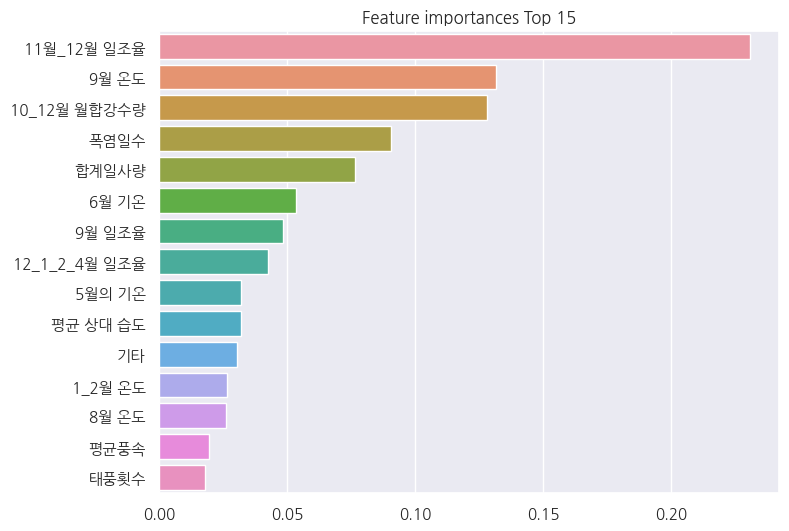

In [64]:
ftr_importances_values = xgb_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train_factor.columns)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 15')
sns.barplot(x=ftr_top15, y=ftr_top15.index)
plt.show()

In [65]:
ftr_importances.sort_values(ascending=False)[:15]

11월_12월 일조율      0.230664
9월 온도            0.131653
10_12월 월합강수량     0.128270
폭염일수             0.090578
합계일사량            0.076618
6월 기온            0.053374
9월 일조율           0.048417
12_1_2_4월 일조율    0.042706
5월의 기온           0.032143
평균 상대 습도         0.031868
기타               0.030254
1_2월 온도          0.026582
8월 온도            0.026321
평균풍속             0.019647
태풍횟수             0.018033
dtype: float32

---

## 2) RandomForest

* 하이퍼 파라미터 튜닝

In [66]:
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier 모델 초기화
rf_model = RandomForestClassifier(random_state=42)

# 파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # 트리의 개수
    'max_depth': [4, 5, 6],  # 트리의 최대 깊이
    'min_samples_split': [2, 3, 4],  # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 3],  # 리프 노드의 최소 샘플 수
}

# 그리드 서치를 사용하여 최적의 파라미터 찾기
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train_factor, y_train)

# 최적의 파라미터 출력
best_params = grid_search.best_params_
print("최적의 파라미터:", best_params)

최적의 파라미터: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


* 학습/예측/성능 평가

In [67]:
# 최적의 파라미터로 모델 재초기화 및 학습
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train_factor, y_train)

# 모델을 사용하여 테스트 데이터 예측
y_pred2 = rf_model.predict(X_test_factor)

# 성능 평가
get_clf_eval(y_test, y_pred2)

오차 행렬
[[ 0  6  3  0]
 [ 0 29 22  0]
 [ 0 18 81  2]
 [ 0  3  5  9]]
정확도: 0.6685, 정밀도: 0.6406, 재현율: 0.6685, F1:0.6503


* feature importance

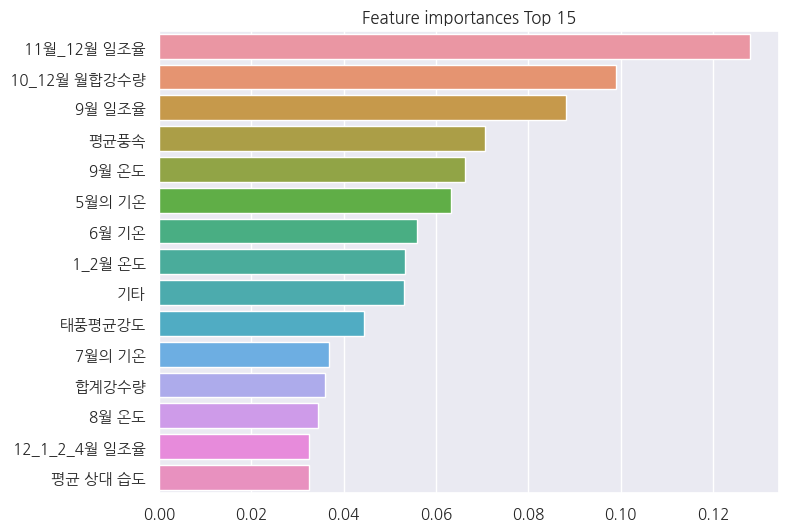

In [68]:
ftr_importances_values = rf_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train_factor.columns)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 15')
sns.barplot(x=ftr_top15, y=ftr_top15.index)
plt.show()

In [69]:
ftr_importances.sort_values(ascending=False)[:10]

11월_12월 일조율     0.127890
10_12월 월합강수량    0.099065
9월 일조율          0.088118
평균풍속            0.070607
9월 온도           0.066301
5월의 기온          0.063300
6월 기온           0.055836
1_2월 온도         0.053191
기타              0.052963
태풍평균강도          0.044345
dtype: float64

---

## 3) SVM

* 하이퍼 파라미터 튜닝

In [70]:
from sklearn.svm import SVC

# SVM 모델을 생성합니다.
svm = SVC()

# 튜닝할 하이퍼파라미터 그리드를 정의합니다.
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'decision_function_shape': ['ovr', 'ovo'],
}

# 그리드 서치
grid_search3 = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)
grid_search3.fit(X_train_factor, y_train)

# 최적의 하이퍼파라미터를 얻습니다.
best_params = grid_search3.best_params_
print('최적 하이퍼 파라미터:\n',grid_search3.best_params_)

최적 하이퍼 파라미터:
 {'C': 0.1, 'decision_function_shape': 'ovr', 'kernel': 'linear'}


* 학습/예측/성능 평가

In [71]:
# 최적의 파라미터로 모델 생성
best_svm = grid_search3.best_estimator_

# 모델 학습
best_svm.fit(X_train_factor, y_train)

# 검증 데이터 예측
y_pred3 = best_svm.predict(X_test_factor)

In [72]:
get_clf_eval(y_test, y_pred3)

오차 행렬
[[ 0  6  3  0]
 [ 0 29 22  0]
 [ 0 18 81  2]
 [ 0  3  5  9]]
정확도: 0.6685, 정밀도: 0.6406, 재현율: 0.6685, F1:0.6503


---

## 4) GradientBoosting

* 하이퍼 파라미터 튜닝

In [73]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting 분류기 초기화
gb_classifier = GradientBoostingClassifier(random_state=42)

# 튜닝할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 7],
}

# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train_factor, y_train)

# 최적의 하이퍼파라미터를 출력
best_params = grid_search.best_params_
print("최적의 하이퍼 파라미터:", best_params)

최적의 하이퍼 파라미터: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}


* 학습/예측/성능 평가

In [74]:
# 최적 모델로 예측
best_gb_model = GradientBoostingClassifier(**best_params)
best_gb_model.fit(X_train_factor, y_train)

# 모델을 사용하여 테스트 데이터 예측
y_pred4 = best_gb_model.predict(X_test_factor)

# 성능 평가
get_clf_eval(y_test, y_pred4)

오차 행렬
[[ 1  5  3  0]
 [ 6 23 22  0]
 [ 3 15 81  2]
 [ 0  3  5  9]]
정확도: 0.6404, 정밀도: 0.6405, 재현율: 0.6404, F1:0.6362


* feature importance

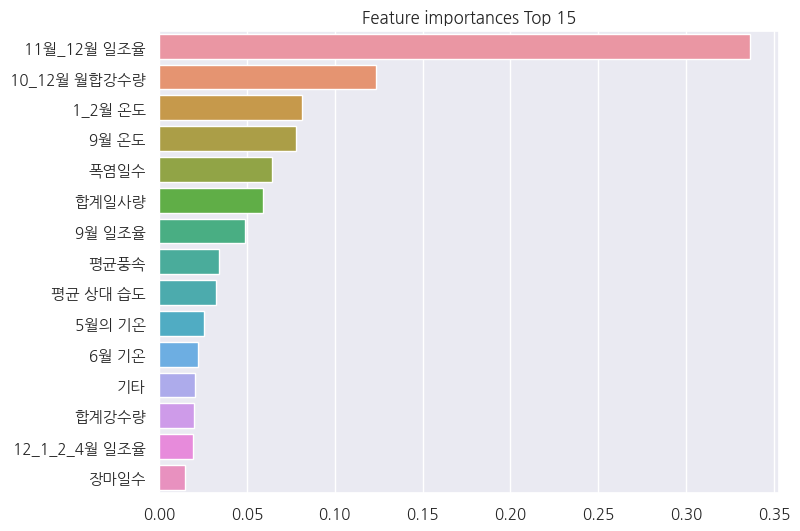

In [75]:
ftr_importances_values = best_gb_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train_factor.columns)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 15')
sns.barplot(x=ftr_top15, y=ftr_top15.index)
plt.show()

In [76]:
ftr_importances.sort_values(ascending=False)[:10]

11월_12월 일조율     0.336130
10_12월 월합강수량    0.123534
1_2월 온도         0.081474
9월 온도           0.077855
폭염일수            0.064363
합계일사량           0.059108
9월 일조율          0.048786
평균풍속            0.033928
평균 상대 습도        0.032439
5월의 기온          0.025596
dtype: float64

---

## 5) AdaBoost

* 하이퍼 파라미터 튜닝

In [77]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# AdaBoost 분류기 초기화
base_classifier = DecisionTreeClassifier(random_state=42)
ada_classifier = AdaBoostClassifier(base_estimator=base_classifier, random_state=42)

# 튜닝할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'base_estimator__max_depth': [2, 3, 4, 5],  # DecisionTreeClassifier의 max_depth 조정
}

# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
grid_search = GridSearchCV(estimator=ada_classifier, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train_factor, y_train)

# 최적의 하이퍼파라미터를 출력
best_params = grid_search.best_params_
print("최적의 하이퍼 파라미터:", best_params)

최적의 하이퍼 파라미터: {'base_estimator__max_depth': 4, 'learning_rate': 0.01, 'n_estimators': 50}


* 학습/예측/성능 평가

In [78]:
# 최적 모델로 예측
best_ada_model = grid_search.best_estimator_
y_pred5 = best_ada_model.predict(X_test_factor)

# 성능 평가
get_clf_eval(y_test, y_pred5)

오차 행렬
[[ 0  6  3  0]
 [ 0 29 22  0]
 [ 0 18 81  2]
 [ 0  3  5  9]]
정확도: 0.6685, 정밀도: 0.6406, 재현율: 0.6685, F1:0.6503


* feature importance

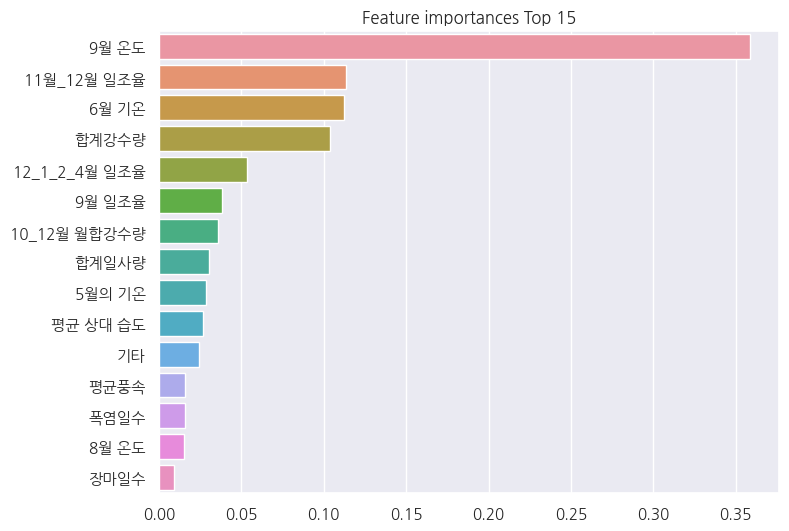

In [79]:
ftr_importances_values = best_ada_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train_factor.columns)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 15')
sns.barplot(x=ftr_top15, y=ftr_top15.index)
plt.show()

In [80]:
ftr_importances.sort_values(ascending=False)[:10]

9월 온도            0.358408
11월_12월 일조율      0.113580
6월 기온            0.112048
합계강수량            0.103643
12_1_2_4월 일조율    0.053530
9월 일조율           0.038268
10_12월 월합강수량     0.035683
합계일사량            0.030400
5월의 기온           0.028639
평균 상대 습도         0.026541
dtype: float64

---

## 6) 앙상블

In [81]:
# Voting Classifier
from sklearn.ensemble import VotingClassifier

# Voting Classifier를 사용하여 앙상블 생성
voting_classifier = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('ada', best_ada_model)],
    voting='hard'
    )

# Voting Classifier 학습
voting_classifier.fit(X_train_factor, y_train)

# 각 모델의 예측을 얻을 수 있습니다.
xgb_predictions = xgb_model.predict(X_test_factor)
rf_predictions = rf_model.predict(X_test_factor)
ada_predictions = best_ada_model.predict(X_test_factor)
voting_predictions = voting_classifier.predict(X_test_factor)

# 성능 평가
get_clf_eval(y_test, voting_predictions)

오차 행렬
[[ 0  6  3  0]
 [ 0 29 22  0]
 [ 0 18 81  2]
 [ 0  3  5  9]]
정확도: 0.6685, 정밀도: 0.6406, 재현율: 0.6685, F1:0.6503


In [82]:
# 스태킹 앙상블
from sklearn.ensemble import StackingClassifier

# 스태킹 앙상블 생성
stacking_models = [
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('ada', best_ada_model)
]

stacking_classifier = StackingClassifier(
    estimators=stacking_models
    )

# 스태킹 앙상블 모델 훈련
stacking_classifier.fit(X_train_factor, y_train)

# 테스트 데이터에 대한 예측
stacking_predictions = stacking_classifier.predict(X_test_factor)

# 성능 평가
get_clf_eval(y_test, stacking_predictions)

오차 행렬
[[ 0  6  3  0]
 [ 0 29 22  0]
 [ 0 18 81  2]
 [ 0  3  5  9]]
정확도: 0.6685, 정밀도: 0.6406, 재현율: 0.6685, F1:0.6503


---

# **10. 결론**
- 기상 데이터의 요인 분석을 통해 새로운 변수를 만들고, 태풍, 폭염일수, 장마의 데이터를 통해 5가지의 학습기를 만들어 예측하였다.
- 최종 모델 : RandomForest

In [83]:
# 모델 저장
# 해당 데이터는 제출했으므로 주석처리
# import pickle

# with open('fuji_rf_model.pkl', 'wb') as model_file:
#     pickle.dump(rf_model, model_file)

---

# **11. 사과 품질에 영향을 미치는 기상요인 분석**


후지에서는 RandomForest 모델의 성능이 가장 높았음

=> RandomForest 모델의 결과를 토대로 사과 품질에 영향을 미치는 기상 요인을 분석

## 1) feature importance

머신러닝 모델에서 각 피처(변수)가 예측 결과에 얼마나 큰 영향을 미치는지를 나타내는 지표

* 이를 이용하면 모델이 어떤 피처를 주로 활용하여 예측을 수행하는지 파악할 수 있음.
* 중요한 피처들은 모델의 예측에 큰 영향을 미치는 요소로 간주됨

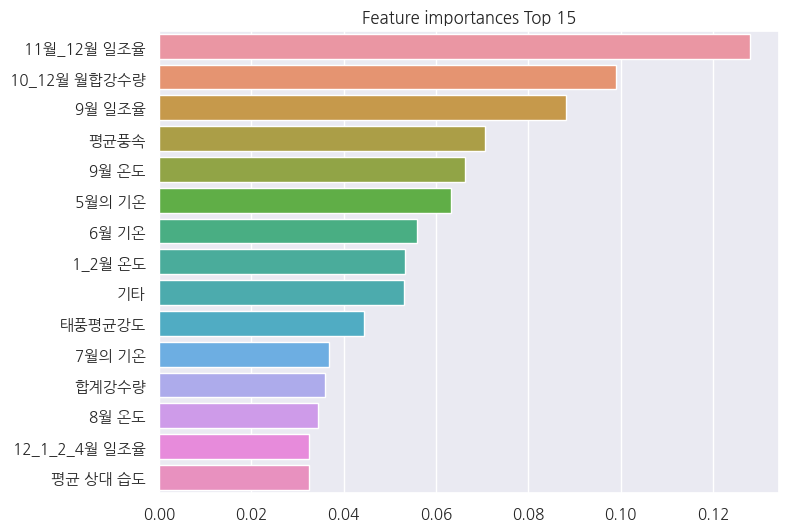

In [84]:
# 랜덤포레스트 모델의 feature importance
ftr_importances_values = rf_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train_factor.columns)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 15')
sns.barplot(x=ftr_top15, y=ftr_top15.index)
plt.show()

>> => 우리 모델에서 가장 중요한 다섯 가지 피처는 '11_12월 일조율', '9월 일조율', '평균풍속', '10_12월 월합강수량', '태풍평균강도'이다. 이 요인들이 사과의 품질을 결정하는 데 큰 영향을 미친다는 것을 알 수 있다.

## 2) SAHP(SHapley Additive exPlanation)
모델의 예측을 해석하는데 사용하기 위해 제안된 방법

#### (1) SAHP(SHapley Additive exPlanation) 개념

* SHAP은 Shapley value를 이용하여 예측에 대해 각 feature의 기여도를 계산하는 기법
* Shapley value는 게임 이론에 기반을 두고 있으며, 이는 feature의 모든 combination에 대해 feature의 기여도를 계산하여 그 값을 평균낸 값이다.


- 하지만, feature의 개수가 늘어날수록 전체 Shapley value를 연산하는데 들어가는 비용이 매우 커지게 된다. 이런 높은 연산 비용을 극복하기 위해 원래 모델의 conditional expectation의 Shapley value를 계산한다


#### (2) SHAP과 feature importance 비교

[feature importance]

permutation 기법을 사용하여 피쳐가 모델에 미치는 영향을 측정한다.

* 장점
    * 측정이 쉬우며 알고리즘이 단순하다.
* 단점
    * 피쳐간의 상호 연관성이 높을 경우 결과가 편향될 수 있다.
    * 음의 영향력은 계산하지 않는다.


[SHAP]

Shapley value를 사용하여 피쳐가 모델에 미치는 영향을 측정한다.

* 장점
    * 피쳐간의 의존성을 고려
    * 음의 영향력을 고려하여, feature importance가 보장하지 못하는 넓은 범위의 함정을 피할 수 있다.

* 단점
    * 기본 계산량이 많아 측정 속도가 느림
    * 기본 계산량을 줄이면 오차 분산이 커져 신뢰도가 떨어진다.

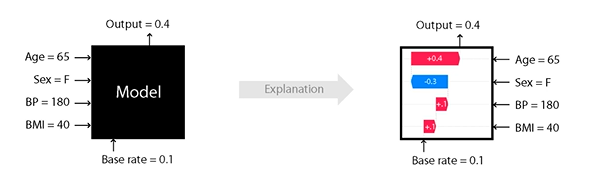

---

### **1. all instance에 대한 plot**

* shap value 구하기

In [85]:
# SHAP 값을 계산
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_factor)

* 전체 class의 Summary Plot

    Summary Plot은 각 클래스에 feature 변수가 미치는 영향을 누적으로 표현한 feature importance plot이다.

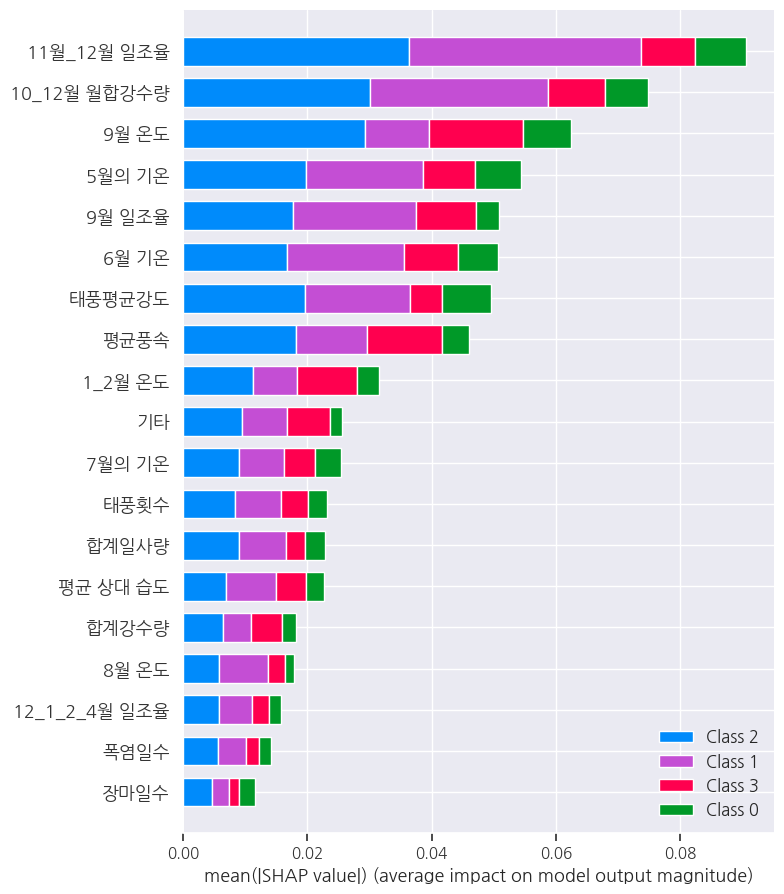

In [86]:
# X_test에 대한 SHAP 값을 시각화
shap.summary_plot(shap_values, X_test_factor.values, plot_type="bar", feature_names = X_test_factor.columns)

1. 그래프로 확인한 결과, 11_12월 일조율과 6월 기온, 9월 일조율, 5월 기온, 태풍평균강도 변수가 전체적으로 미치는 영향이 가장 크다. 다음으로는 10_12월 월합강수량, 9월 온도 등이다.

    => 첫 번째에서 네 번째까지의 변수를 통해 기온과 일조율이 사과의 품질에 영향을 미친다는 것을 알 수 있다.

2. 폭염일수와 장마일수는 품질 결정에 영향을 적게 준다.

3. feature importance와 비교해봤을 때 영향을 주는 변수의 순서가 크게 다르지는 않지만 차이가 있음을 확인할 수 있고, 이는 변수간의 의존성을 고려했기 때문으로 보인다.

* 특정 class의 summary_plot

    * summary plot의 각 점은 Shapley value이다. 이때, 가장 덜 중요한 feature 변수는 값이 0에 가깝다.

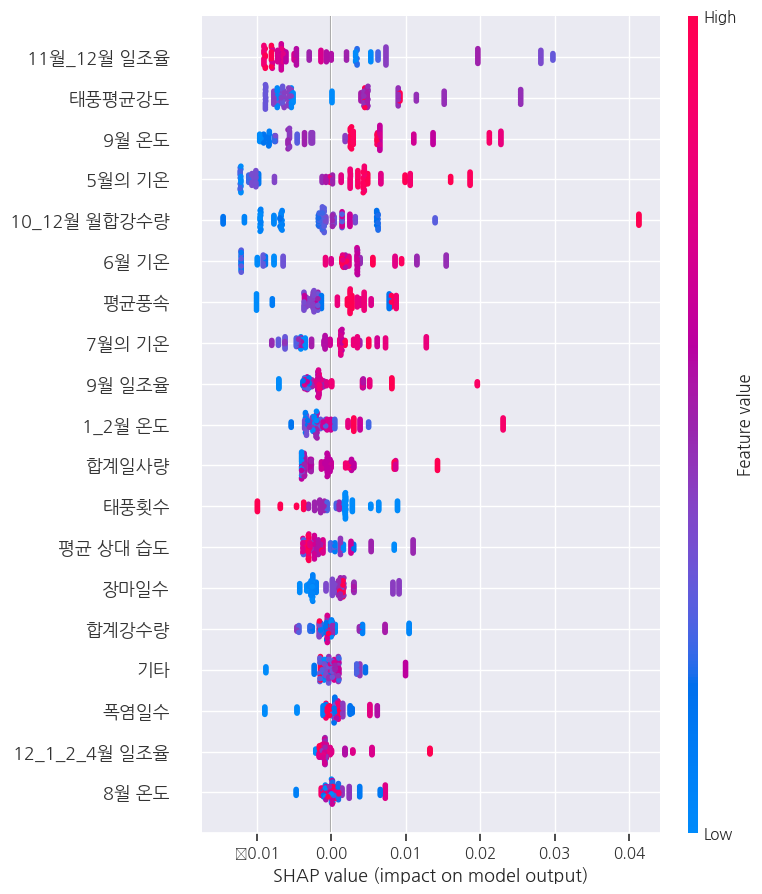

In [87]:
# 클래스 0(1등급)으로 예측할 때
shap.summary_plot(shap_values[0], X_test_factor, title="Class 0 Summary Plot")

1. class 0(1등급)으로 예측할 때, 11월_12월 일조율, 태풍평균강도, 5월의 기온 등에 크게 영향을 받음을 알 수 있다. 이는 11월_12월 일조율, 태풍평균강도, 5월의 기온이 1등급 사과를 결정하는데 주된 요인임을 의미한다.

2. '11월_12월 일조율'의 shapley value를 보면 음의 값을 갖는 점들이 많지만 큰 양의 값을 갖는 점들이 존재한다. 이는 양의 영향력을 줄 때 큰 영향을 미친다는 것을 의미한다.

3. 태풍평균강도 변수를 보면 대부분이 음수의 값을 가진다. 이는 이 변수가 음의 영향력을 가진 변수임을 의미한다.

2. 태풍횟수, 폭염일수, 장마일수는 1등급 사과 결정에 거의 영향을 미치지 않는다.


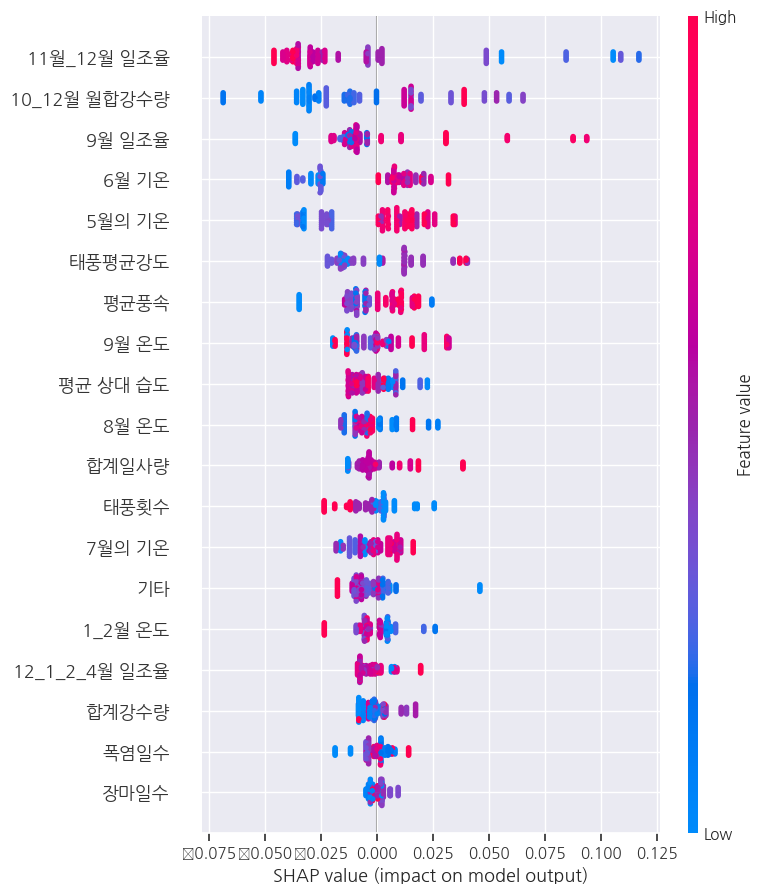

In [88]:
# 클래스 1(2등급)으로 예측할 때
shap.summary_plot(shap_values[1], X_test_factor, title="Class 1 Summary Plot")

1. class 1(2등급)으로 예측할 때, 11_12월 일조율, 6월 기온, 9월 일조율, 5월의 기온, 태풍평균강도에 영향을 많이 받는다. 이를 통해 2등급으로 예측할 때는 일조율과 기온이 중요한 요인임을 알 수 있다.  


2. 폭염일수, 장마일수에는 거의 영향을 받지 않는다.



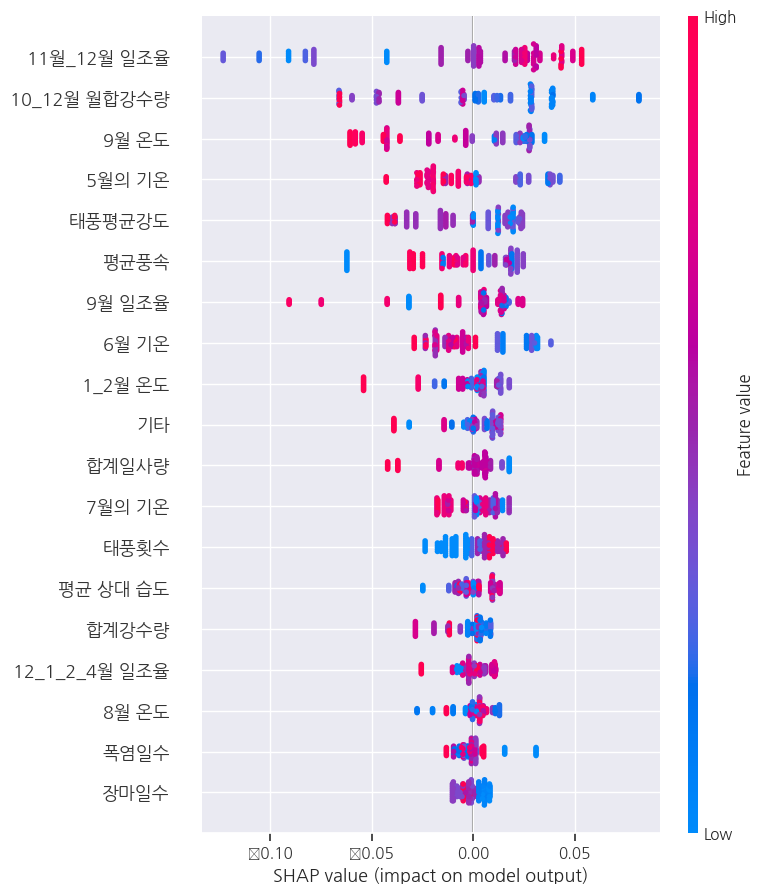

In [89]:
# 클래스 2(3등급)으로 예측할 때
shap.summary_plot(shap_values[2], X_test_factor, title="Class 2 Summary Plot")

1. class 2(3등급)으로 예측할 때, 11_12월 일조율, 5월 기온, 태풍평균강도, 9월 일조율에 영향을 많이 받는다.

2. 11월_12월 일조율의 shapley value는 음과 양 두 방향에서 극단적인 값을 갖는다. 이는 11월_12월 일조율이 예측을 증가시키는 방향으로 기여하기도 하고, 예측을 감소시키는 방향으로도 기여한다는 것을 의미한다.

2. 폭염일수, 장마일수에는 거의 영향을 받지 않는다.


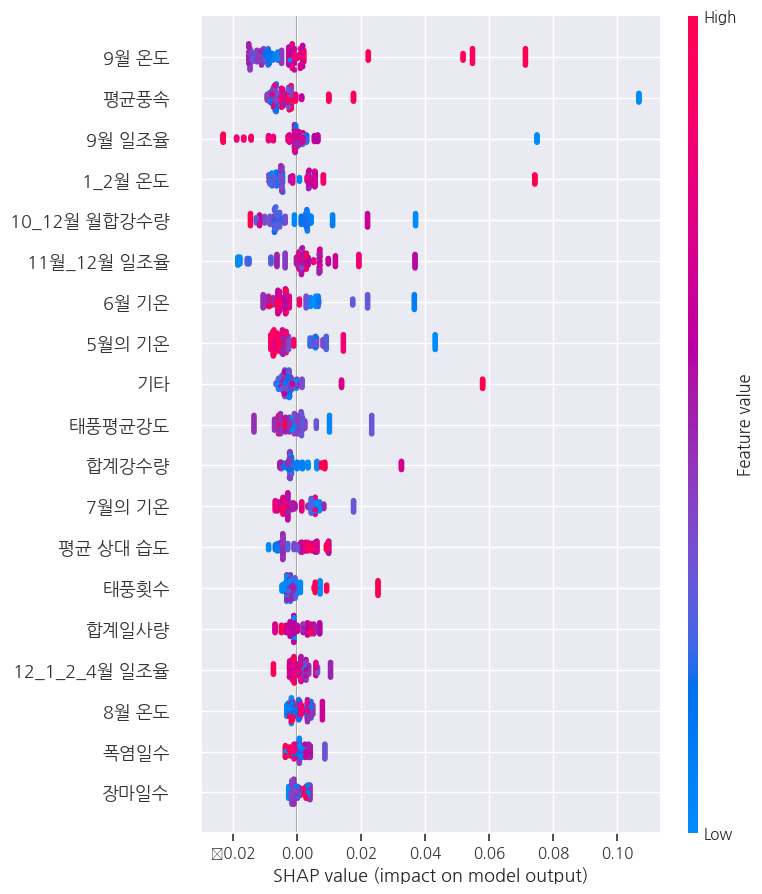

In [90]:
# 클래스 3(4등급)으로 예측할 때
shap.summary_plot(shap_values[3], X_test_factor, title="Class 3 Summary Plot")

1. class 3(4등급)으로 예측할 때, 6월 기온, 평균풍속, 9월온도, 합계강수량 등의 영향을 많이 받는다. 1~3등급의 사과를 결정하는 요인과 크게 다른 것을 확인할 수 있다.

2. 영향을 크게 미치는 변수들의 shapley 값이 대부분 음의 값을 가지며, 몇몇의 value들만 큰 양의 값을 갖는다. 이는 특정 변수가 높은 값을 가질 때 모델 예측이 증가한다는 것을 의미한다.

2. 폭염일수, 장마일수에는 거의 영향을 받지 않는다.
